## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


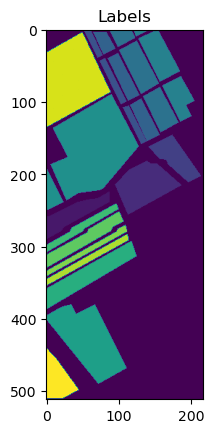

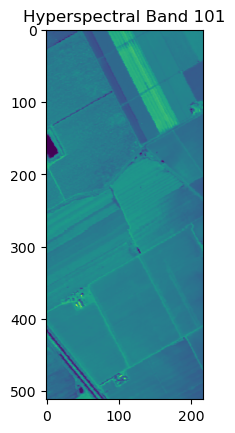

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices for clas


 -- Test set created with: 
	53969 samples
	shape (53969, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(80, 5, 5, 204)
(80, 5, 5, 204)
(53969, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1600, PSNR: 7.0341


	 Training Batch [200/677], Loss: 0.0906, PSNR: 9.6013


	 Training Batch [400/677], Loss: 0.0438, PSNR: 12.5797


	 Training Batch [600/677], Loss: 0.0260, PSNR: 15.0150


Epoch [1/50] Training Loss: 0.0678, PSNR: 11.5650
	[Val]   Batch [1/170] Loss: 0.0217, PSNR: 15.7188
	[Val]   Batch [10/170] Loss: 0.0214, PSNR: 15.8827
	[Val]   Batch [20/170] Loss: 0.0215, PSNR: 15.7873
	[Val]   Batch [30/170] Loss: 0.0222, PSNR: 15.5787
	[Val]   Batch [40/170] Loss: 0.0223, PSNR: 15.6518


	[Val]   Batch [50/170] Loss: 0.0211, PSNR: 15.8638
	[Val]   Batch [60/170] Loss: 0.0221, PSNR: 15.7406
	[Val]   Batch [70/170] Loss: 0.0217, PSNR: 15.8231
	[Val]   Batch [80/170] Loss: 0.0220, PSNR: 15.6406
	[Val]   Batch [90/170] Loss: 0.0213, PSNR: 15.8799


	[Val]   Batch [100/170] Loss: 0.0214, PSNR: 15.7999
	[Val]   Batch [110/170] Loss: 0.0215, PSNR: 15.7866
	[Val]   Batch [120/170] Loss: 0.0202, PSNR: 14.1001
	[Val]   Batch [130/170] Loss: 0.0213, PSNR: 15.8855
	[Val]   Batch [140/170] Loss: 0.0209, PSNR: 15.9390


	[Val]   Batch [150/170] Loss: 0.0224, PSNR: 15.6842
	[Val]   Batch [160/170] Loss: 0.0220, PSNR: 15.7249
	[Val]   Batch [170/170] Loss: 0.0228, PSNR: 15.0127
Epoch [1/50] Validation Loss: 0.0217, PSNR: 15.7084

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0212, PSNR: 15.9196


	 Training Batch [200/677], Loss: 0.0155, PSNR: 17.2888


	 Training Batch [400/677], Loss: 0.0118, PSNR: 18.4276


	 Training Batch [600/677], Loss: 0.0096, PSNR: 19.2670


Epoch [2/50] Training Loss: 0.0134, PSNR: 17.9743
	[Val]   Batch [1/170] Loss: 0.0090, PSNR: 19.5552
	[Val]   Batch [10/170] Loss: 0.0085, PSNR: 19.8989
	[Val]   Batch [20/170] Loss: 0.0086, PSNR: 19.7682
	[Val]   Batch [30/170] Loss: 0.0093, PSNR: 19.3757
	[Val]   Batch [40/170] Loss: 0.0095, PSNR: 19.3572


	[Val]   Batch [50/170] Loss: 0.0083, PSNR: 19.9269
	[Val]   Batch [60/170] Loss: 0.0093, PSNR: 19.5078
	[Val]   Batch [70/170] Loss: 0.0091, PSNR: 19.6052
	[Val]   Batch [80/170] Loss: 0.0091, PSNR: 19.4630
	[Val]   Batch [90/170] Loss: 0.0087, PSNR: 19.7552


	[Val]   Batch [100/170] Loss: 0.0088, PSNR: 19.6762
	[Val]   Batch [110/170] Loss: 0.0086, PSNR: 19.7344
	[Val]   Batch [120/170] Loss: 0.0075, PSNR: 18.3912
	[Val]   Batch [130/170] Loss: 0.0087, PSNR: 19.7651
	[Val]   Batch [140/170] Loss: 0.0081, PSNR: 20.0456


	[Val]   Batch [150/170] Loss: 0.0095, PSNR: 19.4000
	[Val]   Batch [160/170] Loss: 0.0092, PSNR: 19.4987
	[Val]   Batch [170/170] Loss: 0.0095, PSNR: 18.8238
Epoch [2/50] Validation Loss: 0.0089, PSNR: 19.6036

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0098, PSNR: 19.2673


	 Training Batch [200/677], Loss: 0.0073, PSNR: 20.4986


	 Training Batch [400/677], Loss: 0.0069, PSNR: 20.7662


	 Training Batch [600/677], Loss: 0.0059, PSNR: 21.4350


Epoch [3/50] Training Loss: 0.0068, PSNR: 20.8333
	[Val]   Batch [1/170] Loss: 0.0051, PSNR: 21.9724
	[Val]   Batch [10/170] Loss: 0.0048, PSNR: 22.3379
	[Val]   Batch [20/170] Loss: 0.0049, PSNR: 22.2084
	[Val]   Batch [30/170] Loss: 0.0053, PSNR: 21.7741
	[Val]   Batch [40/170] Loss: 0.0055, PSNR: 21.7175
	[Val]   Batch [50/170] Loss: 0.0047, PSNR: 22.3452


	[Val]   Batch [60/170] Loss: 0.0054, PSNR: 21.8952
	[Val]   Batch [70/170] Loss: 0.0052, PSNR: 21.9875
	[Val]   Batch [80/170] Loss: 0.0052, PSNR: 21.8868
	[Val]   Batch [90/170] Loss: 0.0050, PSNR: 22.1402
	[Val]   Batch [100/170] Loss: 0.0051, PSNR: 22.0508


	[Val]   Batch [110/170] Loss: 0.0050, PSNR: 22.1373
	[Val]   Batch [120/170] Loss: 0.0043, PSNR: 20.8608
	[Val]   Batch [130/170] Loss: 0.0050, PSNR: 22.1556
	[Val]   Batch [140/170] Loss: 0.0046, PSNR: 22.5189


	[Val]   Batch [150/170] Loss: 0.0055, PSNR: 21.7872
	[Val]   Batch [160/170] Loss: 0.0053, PSNR: 21.8865
	[Val]   Batch [170/170] Loss: 0.0054, PSNR: 21.3051
Epoch [3/50] Validation Loss: 0.0051, PSNR: 22.0245

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0044, PSNR: 22.3236


	 Training Batch [200/677], Loss: 0.0050, PSNR: 22.2231


	 Training Batch [400/677], Loss: 0.0034, PSNR: 23.8155


	 Training Batch [600/677], Loss: 0.0033, PSNR: 24.0587


Epoch [4/50] Training Loss: 0.0039, PSNR: 23.2368
	[Val]   Batch [1/170] Loss: 0.0029, PSNR: 24.4992
	[Val]   Batch [10/170] Loss: 0.0028, PSNR: 24.7673
	[Val]   Batch [20/170] Loss: 0.0028, PSNR: 24.6480
	[Val]   Batch [30/170] Loss: 0.0030, PSNR: 24.2109
	[Val]   Batch [40/170] Loss: 0.0030, PSNR: 24.3329


	[Val]   Batch [50/170] Loss: 0.0028, PSNR: 24.6304
	[Val]   Batch [60/170] Loss: 0.0030, PSNR: 24.4141
	[Val]   Batch [70/170] Loss: 0.0029, PSNR: 24.5794
	[Val]   Batch [80/170] Loss: 0.0029, PSNR: 24.4484
	[Val]   Batch [90/170] Loss: 0.0029, PSNR: 24.5966


	[Val]   Batch [100/170] Loss: 0.0030, PSNR: 24.3996
	[Val]   Batch [110/170] Loss: 0.0028, PSNR: 24.6104
	[Val]   Batch [120/170] Loss: 0.0026, PSNR: 22.9626
	[Val]   Batch [130/170] Loss: 0.0029, PSNR: 24.4929


	[Val]   Batch [140/170] Loss: 0.0026, PSNR: 24.9193
	[Val]   Batch [150/170] Loss: 0.0030, PSNR: 24.3620
	[Val]   Batch [160/170] Loss: 0.0029, PSNR: 24.4545
	[Val]   Batch [170/170] Loss: 0.0030, PSNR: 23.8543
Epoch [4/50] Validation Loss: 0.0029, PSNR: 24.4872

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0029, PSNR: 24.5433


	 Training Batch [200/677], Loss: 0.0027, PSNR: 24.8377


	 Training Batch [400/677], Loss: 0.0025, PSNR: 25.1144


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.6991


Epoch [5/50] Training Loss: 0.0025, PSNR: 25.1383
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3398
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6073
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.4218
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9405
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2509


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.4141
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2056
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4810
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2868


	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4287
	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0977
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5635
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6461
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1647


	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7644
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1553
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2882
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6115
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2824

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0022, PSNR: 25.3252


	 Training Batch [200/677], Loss: 0.0021, PSNR: 25.9349


	 Training Batch [400/677], Loss: 0.0021, PSNR: 26.0133


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.6303


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.4565
	[Val]   Batch [1/170] Loss: 0.0015, PSNR: 27.4530
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.7014
	[Val]   Batch [20/170] Loss: 0.0015, PSNR: 27.4816
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 26.9742
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.4204


	[Val]   Batch [50/170] Loss: 0.0015, PSNR: 27.4762
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.2812
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.6610
	[Val]   Batch [80/170] Loss: 0.0015, PSNR: 27.3873
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.5615


	[Val]   Batch [100/170] Loss: 0.0016, PSNR: 27.1215
	[Val]   Batch [110/170] Loss: 0.0014, PSNR: 27.7683
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.6774
	[Val]   Batch [130/170] Loss: 0.0016, PSNR: 27.1898
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.8835


	[Val]   Batch [150/170] Loss: 0.0016, PSNR: 27.2101
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4007
	[Val]   Batch [170/170] Loss: 0.0016, PSNR: 26.6699
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.3626

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0018, PSNR: 25.9989


	 Training Batch [200/677], Loss: 0.0016, PSNR: 27.2012


	 Training Batch [400/677], Loss: 0.0013, PSNR: 27.9350


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.6076


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4488
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6803
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.9399
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6713
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.1307
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.7117


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.6139
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4876
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9417
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6427
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7925


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2557
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0849
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7406
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3335


	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.1107
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.4145
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6242
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9626
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5713

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.2549


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.2597


	 Training Batch [400/677], Loss: 0.0013, PSNR: 28.1724


	 Training Batch [600/677], Loss: 0.0013, PSNR: 28.1821


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2928
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.4828
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.7800
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.4986
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9097
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5640


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3717
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.2900
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.7802
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.4881
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.6249


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.0407
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.9760
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.4738
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1190
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9404


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2151
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.4278
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8368
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.3811

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.6246


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.8722


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.4915


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.1709


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0003
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.4149
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6996
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.4011
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.7933
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.5109
	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2222


	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1969
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.7508
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.4272
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6088
	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9555


	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.9555
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3577
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0304
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8929
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0950


	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.3271
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.7834
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2936

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.0258


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.0001


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.9098


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.6324


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6507
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.1982
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.5243
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.1769
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.5957
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.3125


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.9291
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 31.0039
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.5443
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.2756
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.4581


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.8005
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.7979
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.1034
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.8848
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6992


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.9347
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.1005
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.7356
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.1004

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0012


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.7438


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4906


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.7734


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2338
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.9148
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.2605
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.8343
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.3581
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.0443


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.6470
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.7481
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2265
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.0218
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.2339


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5870
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.5405
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8344
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.6488
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.4322


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.6915
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.7942
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.5167
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.8228

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.8457


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.6002


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8304


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.4536


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7759
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.5196
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.8710
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.4127
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.0088
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.6457


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1909
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.4045
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.8064
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.6842
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.9371


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.2775
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.1564
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.4212
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.3748
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.0339


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.3628
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.3681
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.2596
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.4544

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0203


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.7144


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.8893


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1032


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2301
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.1996
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.6076
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.0666
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.7326
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.3544


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.8586
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.1212
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.4593
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.4156
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6863


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0284
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.8797
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.1387
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.1078
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7388


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0933
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.0085
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 33.1311
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.1551

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.6273


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9988


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6775


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8423


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6524
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5812
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.0177
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.4423
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1836
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.7349


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.2558
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.5647
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7901
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.8300
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.1437


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.5078
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.2587
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.6034
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5675


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.1569
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.5418
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3826
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.5184
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.5598

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0301


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.3136


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8516


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.6155


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9464
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.9615
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.4206
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8106
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.6065
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1185


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.6495
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.9680
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.1548
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.2403
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.5750


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.9686
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6272
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0356
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.0365
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5360


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.9711
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.7348
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.0194
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.9617

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.2039


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3656


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.6101


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5160


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2849
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2806
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.6874
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.0876
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.9310
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.4292


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.9084
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.3117
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.4105
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.5580
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.9277


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.3206
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.9202
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.3543
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.3898
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8200


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.3078
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.0200
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3807
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.2660

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.9343


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.0131


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.5392


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2606


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5750
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.8830
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2905
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6133
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5463
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0368


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4229
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9277
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0108
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2004
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5525


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9531
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5199
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.8725
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0225
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3916


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9562
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5836
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.1305
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8600
Early stopping triggered at epoch 17. No improvement for 3 epochs.


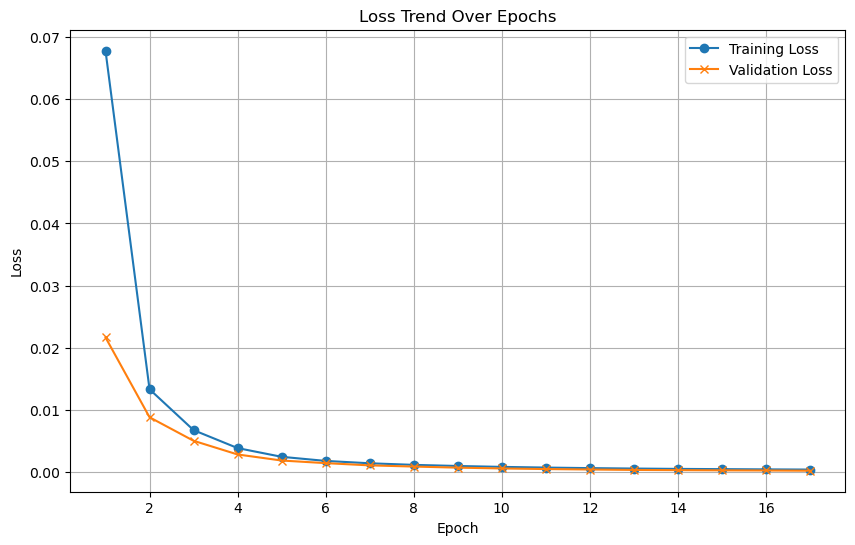

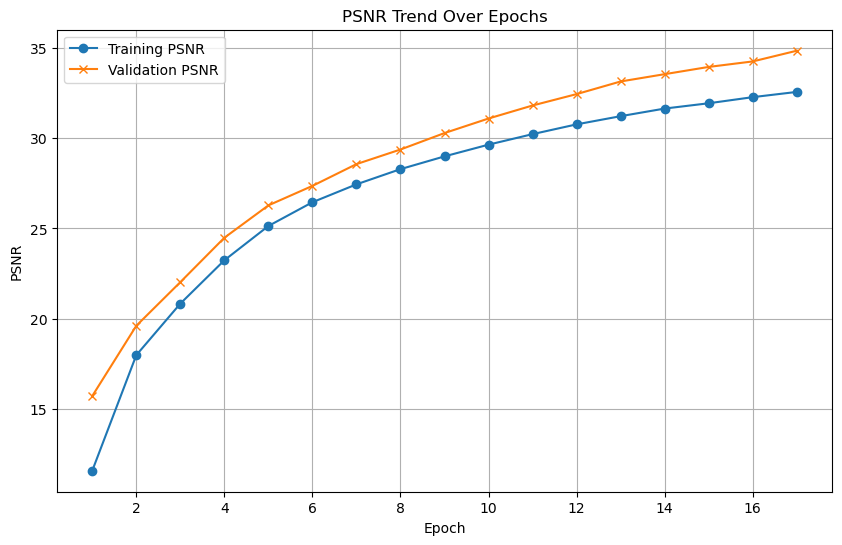

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8107
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7794. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7436
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7360
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6915
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [7/1000] completed, Average Training Loss: 2.6209
    Validation Batch [1/1], Loss: 2.7796
Validation Loss: 2.7796, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6310
    Validation Batch [1/1], Loss: 2.7798
Validation Loss: 2.7798, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.5948
    Validation Batch [1/1], Loss: 2.7798
Validation Loss: 2.7798, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.5889
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.5577
    Validation Batch

    Validation Batch [1/1], Loss: 2.7554
Validation Loss: 2.7554, Validation Accuracy: 6.25%
Validation loss improved from 2.7599 to 2.7554. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.3106
    Validation Batch [1/1], Loss: 2.7500
Validation Loss: 2.7500, Validation Accuracy: 6.25%
Validation loss improved from 2.7554 to 2.7500. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.2776
    Validation Batch [1/1], Loss: 2.7436
Validation Loss: 2.7436, Validation Accuracy: 6.25%
Validation loss improved from 2.7500 to 2.7436. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.2873
    Validation Batch [1/1], Loss: 2.7365
Validation Loss: 2.7365, Validation Accuracy: 6.25%
Validation loss improved from 2.7436 to 2.7365. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.2512
    Validati

Epoch [65/1000] completed, Average Training Loss: 2.0780
    Validation Batch [1/1], Loss: 2.2481
Validation Loss: 2.2481, Validation Accuracy: 56.25%
Validation loss improved from 2.2631 to 2.2481. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.1107
    Validation Batch [1/1], Loss: 2.2361
Validation Loss: 2.2361, Validation Accuracy: 56.25%
Validation loss improved from 2.2481 to 2.2361. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.0364
    Validation Batch [1/1], Loss: 2.2160
Validation Loss: 2.2160, Validation Accuracy: 56.25%
Validation loss improved from 2.2361 to 2.2160. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.0083
    Validation Batch [1/1], Loss: 2.2016
Validation Loss: 2.2016, Validation Accuracy: 56.25%
Validation loss improved from 2.2160 to 2.2016. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [6

Epoch [93/1000] completed, Average Training Loss: 1.8794
    Validation Batch [1/1], Loss: 1.9219
Validation Loss: 1.9219, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.8498
    Validation Batch [1/1], Loss: 1.9190
Validation Loss: 1.9190, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.8239
    Validation Batch [1/1], Loss: 1.8872
Validation Loss: 1.8872, Validation Accuracy: 56.25%
Validation loss improved from 1.9131 to 1.8872. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.8512
    Validation Batch [1/1], Loss: 1.8817
Validation Loss: 1.8817, Validation Accuracy: 56.25%
Validation loss improved from 1.8872 to 1.8817. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Tra

Epoch [122/1000] completed, Average Training Loss: 1.6434
    Validation Batch [1/1], Loss: 1.7247
Validation Loss: 1.7247, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6309
    Validation Batch [1/1], Loss: 1.7223
Validation Loss: 1.7223, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6037
    Validation Batch [1/1], Loss: 1.6904
Validation Loss: 1.6904, Validation Accuracy: 60.00%
Validation loss improved from 1.7149 to 1.6904. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6000
    Validation Batch [1/1], Loss: 1.6886
Validation Loss: 1.6886, Validation Accuracy: 60.00%
Validation loss improved from 1.6904 to 1.6886. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Av

Epoch [150/1000] completed, Average Training Loss: 1.4066
    Validation Batch [1/1], Loss: 1.5479
Validation Loss: 1.5479, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.4400
    Validation Batch [1/1], Loss: 1.5188
Validation Loss: 1.5188, Validation Accuracy: 62.50%
Validation loss improved from 1.5214 to 1.5188. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4452
    Validation Batch [1/1], Loss: 1.5031
Validation Loss: 1.5031, Validation Accuracy: 70.00%
Validation loss improved from 1.5188 to 1.5031. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3759
    Validation Batch [1/1], Loss: 1.4879
Validation Loss: 1.4879, Validation Accuracy: 70.00%
Validation loss improved from 1.5031 to 1.4879. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000

Epoch [179/1000] completed, Average Training Loss: 1.2182
    Validation Batch [1/1], Loss: 1.3440
Validation Loss: 1.3440, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.2139
    Validation Batch [1/1], Loss: 1.3177
Validation Loss: 1.3177, Validation Accuracy: 80.00%
Validation loss improved from 1.3281 to 1.3177. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.2107
    Validation Batch [1/1], Loss: 1.3086
Validation Loss: 1.3086, Validation Accuracy: 82.50%
Validation loss improved from 1.3177 to 1.3086. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.2022
    Validation Batch [1/1], Loss: 1.3120
Validation Loss: 1.3120, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Av

Epoch [210/1000] completed, Average Training Loss: 0.9928
    Validation Batch [1/1], Loss: 1.1513
Validation Loss: 1.1513, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0023
    Validation Batch [1/1], Loss: 1.1280
Validation Loss: 1.1280, Validation Accuracy: 85.00%
Validation loss improved from 1.1335 to 1.1280. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.9709
    Validation Batch [1/1], Loss: 1.1074
Validation Loss: 1.1074, Validation Accuracy: 85.00%
Validation loss improved from 1.1280 to 1.1074. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.9641
    Validation Batch [1/1], Loss: 1.1037
Validation Loss: 1.1037, Validation Accuracy: 86.25%
Validation loss improved from 1.1074 to 1.1037. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000

Epoch [238/1000] completed, Average Training Loss: 0.8142
    Validation Batch [1/1], Loss: 0.9870
Validation Loss: 0.9870, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7927
    Validation Batch [1/1], Loss: 0.9659
Validation Loss: 0.9659, Validation Accuracy: 86.25%
Validation loss improved from 0.9698 to 0.9659. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.8210
    Validation Batch [1/1], Loss: 0.9399
Validation Loss: 0.9399, Validation Accuracy: 86.25%
Validation loss improved from 0.9659 to 0.9399. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.7951
    Validation Batch [1/1], Loss: 0.9561
Validation Loss: 0.9561, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Av

Epoch [268/1000] completed, Average Training Loss: 0.6396
    Validation Batch [1/1], Loss: 0.8052
Validation Loss: 0.8052, Validation Accuracy: 90.00%
Validation loss improved from 0.8087 to 0.8052. Saving model...

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.6930
    Validation Batch [1/1], Loss: 0.8015
Validation Loss: 0.8015, Validation Accuracy: 88.75%
Validation loss improved from 0.8052 to 0.8015. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.6257
    Validation Batch [1/1], Loss: 0.7993
Validation Loss: 0.7993, Validation Accuracy: 88.75%
Validation loss improved from 0.8015 to 0.7993. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.6057
    Validation Batch [1/1], Loss: 0.7983
Validation Loss: 0.7983, Validation Accuracy: 90.00%
Validation loss improved from 0.7993 to 0.7983. Saving model...

LOG: Epoch [272/1000] - Training


Epoch [297/1000] completed, Average Training Loss: 0.4945
    Validation Batch [1/1], Loss: 0.7145
Validation Loss: 0.7145, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.5079
    Validation Batch [1/1], Loss: 0.7074
Validation Loss: 0.7074, Validation Accuracy: 91.25%
Validation loss improved from 0.7092 to 0.7074. Saving model...

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.4960
    Validation Batch [1/1], Loss: 0.6887
Validation Loss: 0.6887, Validation Accuracy: 91.25%
Validation loss improved from 0.7074 to 0.6887. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.4699
    Validation Batch [1/1], Loss: 0.6921
Validation Loss: 0.6921, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6010
Validation Loss: 0.6010, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.4579
    Validation Batch [1/1], Loss: 0.6372
Validation Loss: 0.6372, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.4040
    Validation Batch [1/1], Loss: 0.6668
Validation Loss: 0.6668, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.4320
    Validation Batch [1/1], Loss: 0.5849
Validation Loss: 0.5849, Validation Accuracy: 93.75%
Validation loss improved from 0.5895 to 0.5849. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3789
    Validation Batch [1/1], Loss: 0.5905
Vali

Epoch [358/1000] completed, Average Training Loss: 0.3296
    Validation Batch [1/1], Loss: 0.5413
Validation Loss: 0.5413, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.2951
    Validation Batch [1/1], Loss: 0.5402
Validation Loss: 0.5402, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.3312
    Validation Batch [1/1], Loss: 0.5228
Validation Loss: 0.5228, Validation Accuracy: 92.50%
Validation loss improved from 0.5331 to 0.5228. Saving model...

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.3393
    Validation Batch [1/1], Loss: 0.5087
Validation Loss: 0.5087, Validation Accuracy: 92.50%
Validation loss improved from 0.5228 to 0.5087. Saving model...

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, 

Epoch [388/1000] completed, Average Training Loss: 0.2649
    Validation Batch [1/1], Loss: 0.4691
Validation Loss: 0.4691, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2920
    Validation Batch [1/1], Loss: 0.4585
Validation Loss: 0.4585, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.2992
    Validation Batch [1/1], Loss: 0.4648
Validation Loss: 0.4648, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.2251
    Validation Batch [1/1], Loss: 0.4743
Validation Loss: 0.4743, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.2710
  

    Validation Batch [1/1], Loss: 0.4032
Validation Loss: 0.4032, Validation Accuracy: 93.75%
Validation loss improved from 0.4250 to 0.4032. Saving model...

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.2075
    Validation Batch [1/1], Loss: 0.3993
Validation Loss: 0.3993, Validation Accuracy: 93.75%
Validation loss improved from 0.4032 to 0.3993. Saving model...

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.2347
    Validation Batch [1/1], Loss: 0.4234
Validation Loss: 0.4234, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1931
    Validation Batch [1/1], Loss: 0.4458
Validation Loss: 0.4458, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.2167
    Validation Batch [1/1], Lo

Epoch [450/1000] completed, Average Training Loss: 0.1595
    Validation Batch [1/1], Loss: 0.4025
Validation Loss: 0.4025, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1898
    Validation Batch [1/1], Loss: 0.4324
Validation Loss: 0.4324, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.2139
    Validation Batch [1/1], Loss: 0.4572
Validation Loss: 0.4572, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1675
    Validation Batch [1/1], Loss: 0.4502
Validation Loss: 0.4502, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1647


Epoch [480/1000] completed, Average Training Loss: 0.1714
    Validation Batch [1/1], Loss: 0.3961
Validation Loss: 0.3961, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1185
    Validation Batch [1/1], Loss: 0.4184
Validation Loss: 0.4184, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.2016
    Validation Batch [1/1], Loss: 0.4268
Validation Loss: 0.4268, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.1396
    Validation Batch [1/1], Loss: 0.4318
Validation Loss: 0.4318, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1508
  

Epoch [510/1000] completed, Average Training Loss: 0.1363
    Validation Batch [1/1], Loss: 0.3807
Validation Loss: 0.3807, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.1138
    Validation Batch [1/1], Loss: 0.3897
Validation Loss: 0.3897, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.1135
    Validation Batch [1/1], Loss: 0.3753
Validation Loss: 0.3753, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.1681
    Validation Batch [1/1], Loss: 0.3710
Validation Loss: 0.3710, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.175

    Validation Batch [1/1], Loss: 0.3706
Validation Loss: 0.3706, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.1327
    Validation Batch [1/1], Loss: 0.3798
Validation Loss: 0.3798, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.3494
Validation Loss: 0.3494, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.1003
    Validation Batch [1/1], Loss: 0.3433
Validation Loss: 0.3433, Validation Accuracy: 92.50%
Validation loss improved from 0.3452 to 0.3433. Saving model...

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.1130
    Validation Batch [1/1], Loss: 0.3585
Vali

Epoch [571/1000] completed, Average Training Loss: 0.1172
    Validation Batch [1/1], Loss: 0.3674
Validation Loss: 0.3674, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.3630
Validation Loss: 0.3630, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.3557
Validation Loss: 0.3557, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.3601
Validation Loss: 0.3601, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.1026
 

Epoch [602/1000] completed, Average Training Loss: 0.0824
    Validation Batch [1/1], Loss: 0.3712
Validation Loss: 0.3712, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.3401
Validation Loss: 0.3401, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0802
    Validation Batch [1/1], Loss: 0.3295
Validation Loss: 0.3295, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Loss: 0.3288
Validation Loss: 0.3288, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0881
  

    Validation Batch [1/1], Loss: 0.3466
Validation Loss: 0.3466, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.3451
Validation Loss: 0.3451, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.3441
Validation Loss: 0.3441, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.3502
Validation Loss: 0.3502, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0959
    Validation Batch [1/1], Loss: 0.3802
Validation Loss

Epoch [661/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.3919
Validation Loss: 0.3919, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0750
    Validation Batch [1/1], Loss: 0.3791
Validation Loss: 0.3791, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.3563
Validation Loss: 0.3563, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.3365
Validation Loss: 0.3365, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.070

    Validation Batch [1/1], Loss: 0.3437
Validation Loss: 0.3437, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.3295
Validation Loss: 0.3295, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.3031
Validation Loss: 0.3031, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.2915
Validation Loss: 0.2915, Validation Accuracy: 93.75%
Validation loss improved from 0.2958 to 0.2915. Saving model...

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.2916
V

Epoch [719/1000] completed, Average Training Loss: 0.0655
    Validation Batch [1/1], Loss: 0.4339
Validation Loss: 0.4339, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.3938
Validation Loss: 0.3938, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.3859
Validation Loss: 0.3859, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0633
    Validation Batch [1/1], Loss: 0.3857
Validation Loss: 0.3857, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.064

    Validation Batch [1/1], Loss: 0.3421
Validation Loss: 0.3421, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.0591
    Validation Batch [1/1], Loss: 0.3365
Validation Loss: 0.3365, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [751/1000] - Training
Epoch [751/1000] completed, Average Training Loss: 0.0788
    Validation Batch [1/1], Loss: 0.3206
Validation Loss: 0.3206, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [752/1000] - Training
Epoch [752/1000] completed, Average Training Loss: 0.0681
    Validation Batch [1/1], Loss: 0.3066
Validation Loss: 0.3066, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [753/1000] - Training
Epoch [753/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.3113
Validation Loss

    Validation Batch [1/1], Loss: 0.2704
Validation Loss: 0.2704, Validation Accuracy: 93.75%
Validation loss improved from 0.2915 to 0.2704. Saving model...

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0457
    Validation Batch [1/1], Loss: 0.2915
Validation Loss: 0.2915, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.3209
Validation Loss: 0.3209, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0550
    Validation Batch [1/1], Loss: 0.3466
Validation Loss: 0.3466, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.3730
Vali

Epoch [805/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.3489
Validation Loss: 0.3489, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.3502
Validation Loss: 0.3502, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.3567
Validation Loss: 0.3567, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [808/1000] - Training
Epoch [808/1000] completed, Average Training Loss: 0.0529
    Validation Batch [1/1], Loss: 0.3600
Validation Loss: 0.3600, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [809/1000] - Training
Epoch [809/1000] completed, Average Training Loss: 0.040

    Validation Batch [1/1], Loss: 0.3817
Validation Loss: 0.3817, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [836/1000] - Training
Epoch [836/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.4167
Validation Loss: 0.4167, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [837/1000] - Training
Epoch [837/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.4145
Validation Loss: 0.4145, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [838/1000] - Training
Epoch [838/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.4042
Validation Loss: 0.4042, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [839/1000] - Training
Epoch [839/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.3965
Validation Loss

Epoch [865/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.3395
Validation Loss: 0.3395, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [866/1000] - Training
Epoch [866/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.3475
Validation Loss: 0.3475, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [867/1000] - Training
Epoch [867/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], Loss: 0.3775
Validation Loss: 0.3775, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [868/1000] - Training
Epoch [868/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.3944
Validation Loss: 0.3944, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [869/1000] - Training
Epoch [869/1000] completed, Average Training Loss: 0.026

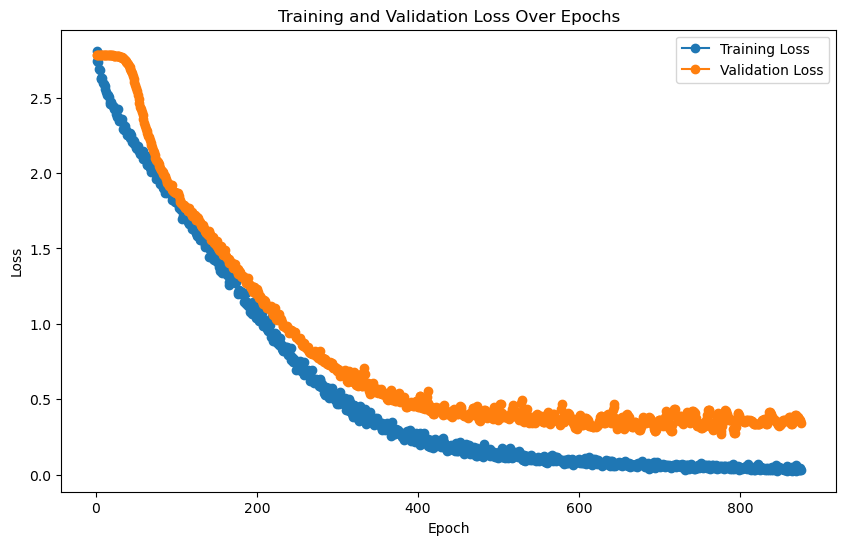

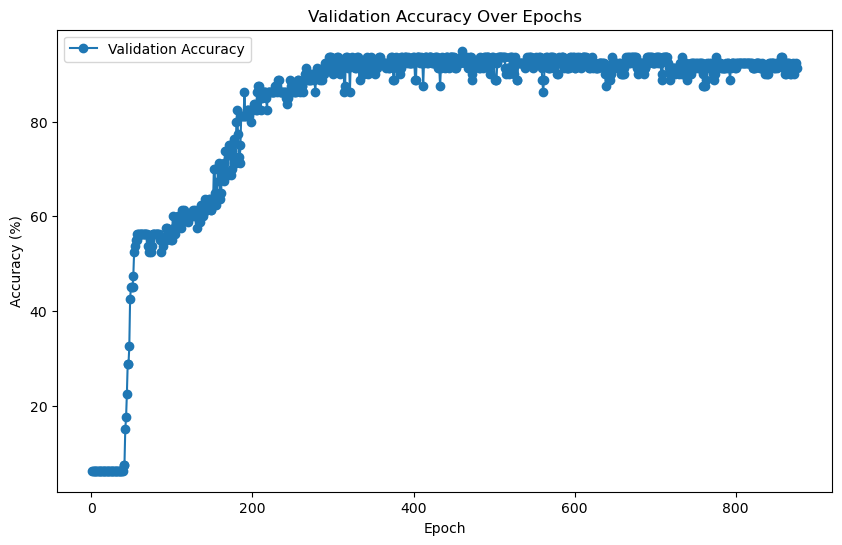


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3106



Final Test Loss: 0.5300, Test Accuracy: 85.64%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53969, 64), Test labels shape: (53969,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.75      0.60      0.67         5
           3       0.83      1.00      0.91         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.71      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53969, 64)
Test labels shape: (53969,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7881  |  Val Loss: 2.6971
Validation loss improved from inf to 2.6971.
[Epoch 2/1000] Train Loss: 2.6907  |  Val Loss: 2.6391
Validation loss improved from 2.6971 to 2.6391.
[Epoch 3/1000] Train Loss: 2.6352  |  Val Loss: 2.5886
Validation loss improved from 2.6391 to 2.5886.
[Epoch 4/1000] Train Loss: 2.5852  |  Val Loss: 2.5414
Validation loss improved from 2.5886 to 2.5414.
[Epoch 5/1000] Train Loss: 2.5405  |  Val Loss: 2.5015
Validation loss improved from 2.5414 to 2.5015.
[Epoch 6/1000] Train Loss: 2.4982  |  Val Loss: 2.4563
Validation loss improved from 2.5015 to 2.4563.
[Epoch 7/1000] Train Loss: 2.4491  |  Val Loss: 2.4013
Validation loss improved from 2.4563 to 2.4013.
[Epoch 8/1000] Train Loss: 2.3927  |  Val Loss: 2.3496
Validation loss improved from 2.4013 to 2.3496.
[Epoch 9/1000] Train Loss: 2.3428  |  Val Loss: 2.3004
Validation loss improved from 2.3496 to 2.3004.
[Epoch 10/1000] Train Loss: 2.2882  |  Val Loss: 2.2558
Validation loss impr

[Epoch 21/1000] Train Loss: 1.7372  |  Val Loss: 1.7336
Validation loss improved from 1.7786 to 1.7336.
[Epoch 22/1000] Train Loss: 1.6892  |  Val Loss: 1.6878
Validation loss improved from 1.7336 to 1.6878.
[Epoch 23/1000] Train Loss: 1.6371  |  Val Loss: 1.6400
Validation loss improved from 1.6878 to 1.6400.
[Epoch 24/1000] Train Loss: 1.5892  |  Val Loss: 1.5925
Validation loss improved from 1.6400 to 1.5925.
[Epoch 25/1000] Train Loss: 1.5407  |  Val Loss: 1.5479
Validation loss improved from 1.5925 to 1.5479.
[Epoch 26/1000] Train Loss: 1.4934  |  Val Loss: 1.5047
Validation loss improved from 1.5479 to 1.5047.
[Epoch 27/1000] Train Loss: 1.4437  |  Val Loss: 1.4622
Validation loss improved from 1.5047 to 1.4622.
[Epoch 28/1000] Train Loss: 1.4012  |  Val Loss: 1.4245
Validation loss improved from 1.4622 to 1.4245.
[Epoch 29/1000] Train Loss: 1.3588  |  Val Loss: 1.3854
Validation loss improved from 1.4245 to 1.3854.
[Epoch 30/1000] Train Loss: 1.3129  |  Val Loss: 1.3461
Validati

[Epoch 43/1000] Train Loss: 0.8864  |  Val Loss: 0.9788
Validation loss improved from 1.0046 to 0.9788.
[Epoch 44/1000] Train Loss: 0.8653  |  Val Loss: 0.9515
Validation loss improved from 0.9788 to 0.9515.
[Epoch 45/1000] Train Loss: 0.8351  |  Val Loss: 0.9280
Validation loss improved from 0.9515 to 0.9280.
[Epoch 46/1000] Train Loss: 0.8054  |  Val Loss: 0.9127
Validation loss improved from 0.9280 to 0.9127.
[Epoch 47/1000] Train Loss: 0.7863  |  Val Loss: 0.8996
Validation loss improved from 0.9127 to 0.8996.
[Epoch 48/1000] Train Loss: 0.7722  |  Val Loss: 0.8828
Validation loss improved from 0.8996 to 0.8828.
[Epoch 49/1000] Train Loss: 0.7511  |  Val Loss: 0.8626
Validation loss improved from 0.8828 to 0.8626.
[Epoch 50/1000] Train Loss: 0.7268  |  Val Loss: 0.8527
Validation loss improved from 0.8626 to 0.8527.
[Epoch 51/1000] Train Loss: 0.7128  |  Val Loss: 0.8437
Validation loss improved from 0.8527 to 0.8437.
[Epoch 52/1000] Train Loss: 0.7037  |  Val Loss: 0.8204
Validati

[Epoch 60/1000] Train Loss: 0.5774  |  Val Loss: 0.7416
Validation loss improved from 0.7497 to 0.7416.
[Epoch 61/1000] Train Loss: 0.5704  |  Val Loss: 0.7401
Validation loss improved from 0.7416 to 0.7401.
[Epoch 62/1000] Train Loss: 0.5644  |  Val Loss: 0.7292
Validation loss improved from 0.7401 to 0.7292.
[Epoch 63/1000] Train Loss: 0.5472  |  Val Loss: 0.7146
Validation loss improved from 0.7292 to 0.7146.
[Epoch 64/1000] Train Loss: 0.5302  |  Val Loss: 0.7067
Validation loss improved from 0.7146 to 0.7067.
[Epoch 65/1000] Train Loss: 0.5174  |  Val Loss: 0.6994
Validation loss improved from 0.7067 to 0.6994.
[Epoch 66/1000] Train Loss: 0.5092  |  Val Loss: 0.6896
Validation loss improved from 0.6994 to 0.6896.
[Epoch 67/1000] Train Loss: 0.4995  |  Val Loss: 0.6828
Validation loss improved from 0.6896 to 0.6828.
[Epoch 68/1000] Train Loss: 0.4923  |  Val Loss: 0.6850
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.4913  |  Val Loss: 0.6773
Va

[Epoch 84/1000] Train Loss: 0.3715  |  Val Loss: 0.6206
Validation loss improved from 0.6313 to 0.6206.
[Epoch 85/1000] Train Loss: 0.3656  |  Val Loss: 0.6247
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.3738  |  Val Loss: 0.6277
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 0.3774  |  Val Loss: 0.6253
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 0.3678  |  Val Loss: 0.6103
Validation loss improved from 0.6206 to 0.6103.
[Epoch 89/1000] Train Loss: 0.3506  |  Val Loss: 0.5957
Validation loss improved from 0.6103 to 0.5957.
[Epoch 90/1000] Train Loss: 0.3526  |  Val Loss: 0.5953
Validation loss improved from 0.5957 to 0.5953.
[Epoch 91/1000] Train Loss: 0.3524  |  Val Loss: 0.5937
Validation loss improved from 0.5953 to 0.5937.
[Epoch 92/1000] Train Loss: 0.3475  |  Val Loss: 0.5881
Validation loss improved from 0.5937 to 0.5881.
[Epoch 93/1000] Train Loss: 0.3371  |  Val Los

[Epoch 101/1000] Train Loss: 0.3012  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.2927  |  Val Loss: 0.5829
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.2885  |  Val Loss: 0.5908
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 0.2815  |  Val Loss: 0.5913
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 105/1000] Train Loss: 0.2773  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 0.2757  |  Val Loss: 0.5802
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 107/1000] Train Loss: 0.2757  |  Val Loss: 0.5775
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 108/1000] Train Loss: 0.2716  |  Val Loss: 0.5768
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 109/1000] Train Loss: 0.2730  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 121/1000] Train Loss: 0.2334  |  Val Loss: 0.5640
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 122/1000] Train Loss: 0.2383  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 123/1000] Train Loss: 0.2371  |  Val Loss: 0.5608
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 124/1000] Train Loss: 0.2303  |  Val Loss: 0.5468
Validation loss improved from 0.5475 to 0.5468.
[Epoch 125/1000] Train Loss: 0.2243  |  Val Loss: 0.5344
Validation loss improved from 0.5468 to 0.5344.
[Epoch 126/1000] Train Loss: 0.2216  |  Val Loss: 0.5343
Validation loss improved from 0.5344 to 0.5343.
[Epoch 127/1000] Train Loss: 0.2184  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.2116  |  Val Loss: 0.5451
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 0.2088  |  Val Loss: 0.5538
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Tr

[Epoch 140/1000] Train Loss: 0.1940  |  Val Loss: 0.5776
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 141/1000] Train Loss: 0.1923  |  Val Loss: 0.5796
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 142/1000] Train Loss: 0.2035  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 143/1000] Train Loss: 0.1952  |  Val Loss: 0.5589
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 144/1000] Train Loss: 0.1943  |  Val Loss: 0.5523
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 145/1000] Train Loss: 0.1975  |  Val Loss: 0.5446
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 146/1000] Train Loss: 0.1906  |  Val Loss: 0.5570
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 147/1000] Train Loss: 0.1858  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 148/1000] Train Loss: 0.2102  |  Val Loss: 0.5913
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.1855  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 165/1000] Train Loss: 0.1793  |  Val Loss: 0.5478
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 166/1000] Train Loss: 0.1540  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 167/1000] Train Loss: 0.1757  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 168/1000] Train Loss: 0.1595  |  Val Loss: 0.5520
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 169/1000] Train Loss: 0.1542  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 170/1000] Train Loss: 0.1597  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 171/1000] Train Loss: 0.1516  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 172/1000] Train Loss: 0.1457  |  Val Loss: 0.5664
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.1341  |  Val Loss: 0.5582
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 180/1000] Train Loss: 0.1347  |  Val Loss: 0.5743
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 181/1000] Train Loss: 0.1350  |  Val Loss: 0.5791
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 182/1000] Train Loss: 0.1340  |  Val Loss: 0.5749
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 183/1000] Train Loss: 0.1348  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 184/1000] Train Loss: 0.1331  |  Val Loss: 0.5627
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 185/1000] Train Loss: 0.1271  |  Val Loss: 0.5728
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 186/1000] Train Loss: 0.1302  |  Val Loss: 0.5820
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 187/1000] Train Loss: 0.1415  |  Val Loss: 0.5670
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.1212  |  Val Loss: 0.5501
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 206/1000] Train Loss: 0.1079  |  Val Loss: 0.5592
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 207/1000] Train Loss: 0.1076  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 208/1000] Train Loss: 0.1151  |  Val Loss: 0.5840
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 209/1000] Train Loss: 0.1119  |  Val Loss: 0.5681
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 210/1000] Train Loss: 0.1038  |  Val Loss: 0.5537
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 211/1000] Train Loss: 0.1062  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 212/1000] Train Loss: 0.1169  |  Val Loss: 0.5597
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 213/1000] Train Loss: 0.1169  |  Val Loss: 0.5704
!! Validation loss did NOT improve !! Patience:

[Epoch 217/1000] Train Loss: 0.1410  |  Val Loss: 0.6315
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 218/1000] Train Loss: 0.1161  |  Val Loss: 0.6090
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 219/1000] Train Loss: 0.1027  |  Val Loss: 0.5997
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 220/1000] Train Loss: 0.0982  |  Val Loss: 0.5943
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 221/1000] Train Loss: 0.0970  |  Val Loss: 0.5928
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 222/1000] Train Loss: 0.0976  |  Val Loss: 0.5930
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 223/1000] Train Loss: 0.0949  |  Val Loss: 0.5872
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 224/1000] Train Loss: 0.0965  |  Val Loss: 0.5848
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 225/1000] Train Loss: 0.0992  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience:

[Epoch 244/1000] Train Loss: 0.0835  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 245/1000] Train Loss: 0.0811  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 246/1000] Train Loss: 0.0832  |  Val Loss: 0.6120
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 247/1000] Train Loss: 0.0913  |  Val Loss: 0.6125
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 248/1000] Train Loss: 0.0907  |  Val Loss: 0.6027
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 249/1000] Train Loss: 0.0846  |  Val Loss: 0.5935
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 250/1000] Train Loss: 0.0836  |  Val Loss: 0.5903
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 251/1000] Train Loss: 0.0877  |  Val Loss: 0.5929
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 252/1000] Train Loss: 0.0889  |  Val Loss: 0.5999
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.0770  |  Val Loss: 0.5964
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 258/1000] Train Loss: 0.0939  |  Val Loss: 0.5916
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 259/1000] Train Loss: 0.0896  |  Val Loss: 0.5931
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 260/1000] Train Loss: 0.0741  |  Val Loss: 0.6186
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 261/1000] Train Loss: 0.0861  |  Val Loss: 0.6271
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 262/1000] Train Loss: 0.0970  |  Val Loss: 0.6050
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 263/1000] Train Loss: 0.0807  |  Val Loss: 0.5920
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 264/1000] Train Loss: 0.1005  |  Val Loss: 0.6078
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 265/1000] Train Loss: 0.0945  |  Val Loss: 0.6201
!! Validation loss did NOT improve !! Patience:

[Epoch 283/1000] Train Loss: 0.0739  |  Val Loss: 0.6013
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 284/1000] Train Loss: 0.0708  |  Val Loss: 0.6051
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 285/1000] Train Loss: 0.0692  |  Val Loss: 0.6135
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 286/1000] Train Loss: 0.0662  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 287/1000] Train Loss: 0.0639  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 288/1000] Train Loss: 0.0649  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 289/1000] Train Loss: 0.0670  |  Val Loss: 0.6339
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 290/1000] Train Loss: 0.0657  |  Val Loss: 0.6394
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 290 !!
No improvement for 100 epochs.


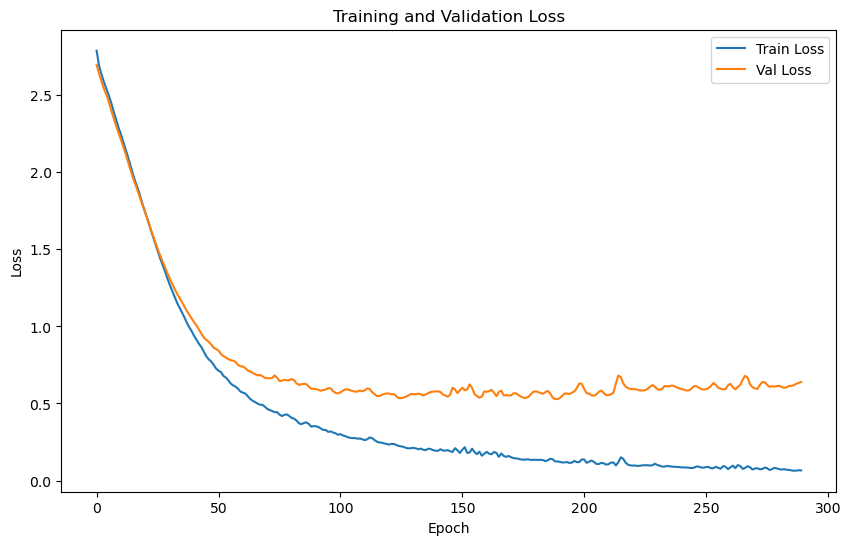

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8349 | Test Accuracy: 78.82%


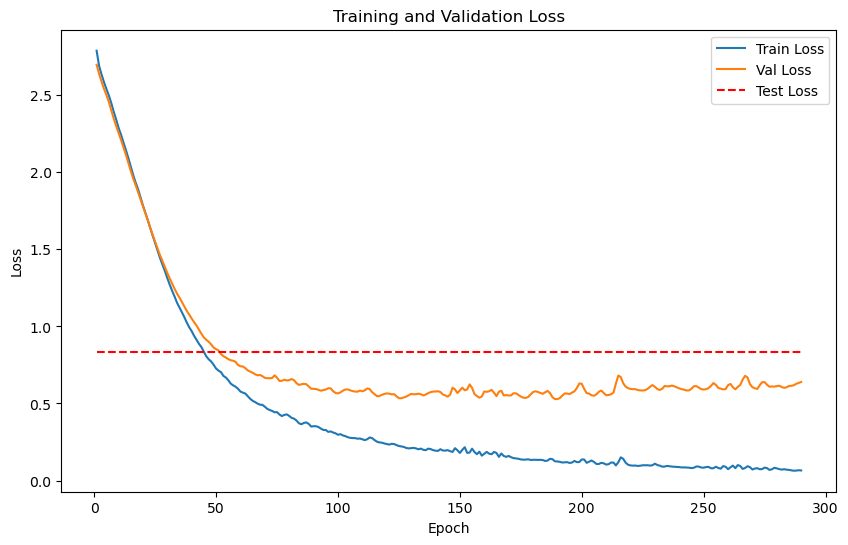

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.3592
Epoch [1/2000], Avg Train Loss: 7.3592


Epoch [1/2000], Avg Val Loss: 3.3413
Validation loss improved from inf to 3.3413. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.3683
Epoch [2/2000], Avg Train Loss: 7.3683
Epoch [2/2000], Avg Val Loss: 3.3285
Validation loss improved from 3.3413 to 3.3285. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.0615
Epoch [3/2000], Avg Train Loss: 7.0615
Epoch [3/2000], Avg Val Loss: 3.3159
Validation loss improved from 3.3285 to 3.3159. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.2599
Epoch [4/2000], Avg Train Loss: 7.2599
Epoch [4/2000], Avg Val Loss: 3.3036
Validation loss improved from 3.3159 to 3.3036. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.1632
Epoch [5/2000], Avg Train Loss: 7.1632
Epoch [5/2000], Avg Val Loss: 3.2917
Validation loss improved from 3.3036 to 3.2917. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.2389
Ep

    Batch [1/1], Train Loss: 6.4708
Epoch [16/2000], Avg Train Loss: 6.4708
Epoch [16/2000], Avg Val Loss: 3.1787
Validation loss improved from 3.1876 to 3.1787. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.5431
Epoch [17/2000], Avg Train Loss: 6.5431
Epoch [17/2000], Avg Val Loss: 3.1701
Validation loss improved from 3.1787 to 3.1701. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.5745
Epoch [18/2000], Avg Train Loss: 6.5745
Epoch [18/2000], Avg Val Loss: 3.1617
Validation loss improved from 3.1701 to 3.1617. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.4455
Epoch [19/2000], Avg Train Loss: 6.4455
Epoch [19/2000], Avg Val Loss: 3.1536
Validation loss improved from 3.1617 to 3.1536. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.1560
Epoch [20/2000], Avg Train Loss: 6.1560
Epoch [20/2000], Avg Val Loss: 3.1457
Validation loss improved from 3.1536 to 3.

    Batch [1/1], Train Loss: 5.0568
Epoch [52/2000], Avg Train Loss: 5.0568
Epoch [52/2000], Avg Val Loss: 2.9907
Validation loss improved from 2.9931 to 2.9907. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 4.7863
Epoch [53/2000], Avg Train Loss: 4.7863
Epoch [53/2000], Avg Val Loss: 2.9884
Validation loss improved from 2.9907 to 2.9884. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 4.8058
Epoch [54/2000], Avg Train Loss: 4.8058
Epoch [54/2000], Avg Val Loss: 2.9862
Validation loss improved from 2.9884 to 2.9862. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 4.7482
Epoch [55/2000], Avg Train Loss: 4.7482
Epoch [55/2000], Avg Val Loss: 2.9840
Validation loss improved from 2.9862 to 2.9840. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 4.6150
Epoch [56/2000], Avg Train Loss: 4.6150
Epoch [56/2000], Avg Val Loss: 2.9821
Validation loss improved from 2.9840 to 2.

Epoch [61/2000], Avg Val Loss: 2.9731
Validation loss improved from 2.9748 to 2.9731. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 4.7151
Epoch [62/2000], Avg Train Loss: 4.7151
Epoch [62/2000], Avg Val Loss: 2.9716
Validation loss improved from 2.9731 to 2.9716. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 4.4319
Epoch [63/2000], Avg Train Loss: 4.4319
Epoch [63/2000], Avg Val Loss: 2.9701
Validation loss improved from 2.9716 to 2.9701. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 4.4453
Epoch [64/2000], Avg Train Loss: 4.4453
Epoch [64/2000], Avg Val Loss: 2.9687
Validation loss improved from 2.9701 to 2.9687. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.4454
Epoch [65/2000], Avg Train Loss: 4.4454
Epoch [65/2000], Avg Val Loss: 2.9674
Validation loss improved from 2.9687 to 2.9674. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 3.8586
Epoch [101/2000], Avg Train Loss: 3.8586
Epoch [101/2000], Avg Val Loss: 2.9484
Validation loss improved from 2.9484 to 2.9484. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 3.9431
Epoch [102/2000], Avg Train Loss: 3.9431
Epoch [102/2000], Avg Val Loss: 2.9483
Validation loss improved from 2.9484 to 2.9483. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 3.9637
Epoch [103/2000], Avg Train Loss: 3.9637
Epoch [103/2000], Avg Val Loss: 2.9483
Validation loss improved from 2.9483 to 2.9483. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 3.8402
Epoch [104/2000], Avg Train Loss: 3.8402
Epoch [104/2000], Avg Val Loss: 2.9483
Validation loss improved from 2.9483 to 2.9483. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 3.8270
Epoch [105/2000], Avg Train Loss: 3.8270
Epoch [105/2000], Avg Val Loss: 2.9482
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8552
Epoch [109/2000], Avg Train Loss: 3.8552
Epoch [109/2000], Avg Val Loss: 2.9476
Validation loss improved from 2.9478 to 2.9476. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 3.8691
Epoch [110/2000], Avg Train Loss: 3.8691
Epoch [110/2000], Avg Val Loss: 2.9474
Validation loss improved from 2.9476 to 2.9474. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 3.9060
Epoch [111/2000], Avg Train Loss: 3.9060
Epoch [111/2000], Avg Val Loss: 2.9472
Validation loss improved from 2.9474 to 2.9472. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 3.9918
Epoch [112/2000], Avg Train Loss: 3.9918
Epoch [112/2000], Avg Val Loss: 2.9470
Validation loss improved from 2.9472 to 2.9470. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 3.6839
Epoch [113/2000], Avg Train Loss: 3.6839
Epoch [113/2000], Avg Val Loss: 2.9468
Validation loss improved fro

Epoch [141/2000], Avg Val Loss: 2.9404
Validation loss improved from 2.9407 to 2.9404. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 3.6801
Epoch [142/2000], Avg Train Loss: 3.6801
Epoch [142/2000], Avg Val Loss: 2.9400
Validation loss improved from 2.9404 to 2.9400. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 3.5541
Epoch [143/2000], Avg Train Loss: 3.5541
Epoch [143/2000], Avg Val Loss: 2.9396
Validation loss improved from 2.9400 to 2.9396. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 3.4866
Epoch [144/2000], Avg Train Loss: 3.4866
Epoch [144/2000], Avg Val Loss: 2.9392
Validation loss improved from 2.9396 to 2.9392. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.4952
Epoch [145/2000], Avg Train Loss: 3.4952
Epoch [145/2000], Avg Val Loss: 2.9388
Validation loss improved from 2.9392 to 2.9388. Saving model...

LOG: Epoch [146/2000] - Training
    Bat

Epoch [154/2000], Avg Val Loss: 2.9348
Validation loss improved from 2.9352 to 2.9348. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 3.5898
Epoch [155/2000], Avg Train Loss: 3.5898
Epoch [155/2000], Avg Val Loss: 2.9344
Validation loss improved from 2.9348 to 2.9344. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 3.6014
Epoch [156/2000], Avg Train Loss: 3.6014
Epoch [156/2000], Avg Val Loss: 2.9340
Validation loss improved from 2.9344 to 2.9340. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 3.6417
Epoch [157/2000], Avg Train Loss: 3.6417
Epoch [157/2000], Avg Val Loss: 2.9335
Validation loss improved from 2.9340 to 2.9335. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 3.5221
Epoch [158/2000], Avg Train Loss: 3.5221
Epoch [158/2000], Avg Val Loss: 2.9331
Validation loss improved from 2.9335 to 2.9331. Saving model...

LOG: Epoch [159/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4492
Epoch [189/2000], Avg Train Loss: 3.4492
Epoch [189/2000], Avg Val Loss: 2.9165
Validation loss improved from 2.9171 to 2.9165. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.3849
Epoch [190/2000], Avg Train Loss: 3.3849
Epoch [190/2000], Avg Val Loss: 2.9158
Validation loss improved from 2.9165 to 2.9158. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 3.4343
Epoch [191/2000], Avg Train Loss: 3.4343
Epoch [191/2000], Avg Val Loss: 2.9151
Validation loss improved from 2.9158 to 2.9151. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 3.4287
Epoch [192/2000], Avg Train Loss: 3.4287
Epoch [192/2000], Avg Val Loss: 2.9144
Validation loss improved from 2.9151 to 2.9144. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 3.3994
Epoch [193/2000], Avg Train Loss: 3.3994
Epoch [193/2000], Avg Val Loss: 2.9137
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3671
Epoch [203/2000], Avg Train Loss: 3.3671
Epoch [203/2000], Avg Val Loss: 2.9062
Validation loss improved from 2.9069 to 2.9062. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.2083
Epoch [204/2000], Avg Train Loss: 3.2083
Epoch [204/2000], Avg Val Loss: 2.9054
Validation loss improved from 2.9062 to 2.9054. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.2868
Epoch [205/2000], Avg Train Loss: 3.2868
Epoch [205/2000], Avg Val Loss: 2.9047
Validation loss improved from 2.9054 to 2.9047. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.3554
Epoch [206/2000], Avg Train Loss: 3.3554
Epoch [206/2000], Avg Val Loss: 2.9039
Validation loss improved from 2.9047 to 2.9039. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.2803
Epoch [207/2000], Avg Train Loss: 3.2803
Epoch [207/2000], Avg Val Loss: 2.9031
Validation loss improved fro

Epoch [232/2000], Avg Val Loss: 2.8830
Validation loss improved from 2.8838 to 2.8830. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.2812
Epoch [233/2000], Avg Train Loss: 3.2812
Epoch [233/2000], Avg Val Loss: 2.8823
Validation loss improved from 2.8830 to 2.8823. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.3429
Epoch [234/2000], Avg Train Loss: 3.3429
Epoch [234/2000], Avg Val Loss: 2.8815
Validation loss improved from 2.8823 to 2.8815. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.2778
Epoch [235/2000], Avg Train Loss: 3.2778
Epoch [235/2000], Avg Val Loss: 2.8807
Validation loss improved from 2.8815 to 2.8807. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.2057
Epoch [236/2000], Avg Train Loss: 3.2057
Epoch [236/2000], Avg Val Loss: 2.8800
Validation loss improved from 2.8807 to 2.8800. Saving model...

LOG: Epoch [237/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1265
Epoch [249/2000], Avg Train Loss: 3.1265
Epoch [249/2000], Avg Val Loss: 2.8703
Validation loss improved from 2.8710 to 2.8703. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.2738
Epoch [250/2000], Avg Train Loss: 3.2738
Epoch [250/2000], Avg Val Loss: 2.8695
Validation loss improved from 2.8703 to 2.8695. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 3.2634
Epoch [251/2000], Avg Train Loss: 3.2634
Epoch [251/2000], Avg Val Loss: 2.8688
Validation loss improved from 2.8695 to 2.8688. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.2024
Epoch [252/2000], Avg Train Loss: 3.2024
Epoch [252/2000], Avg Val Loss: 2.8680
Validation loss improved from 2.8688 to 2.8680. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.2141
Epoch [253/2000], Avg Train Loss: 3.2141
Epoch [253/2000], Avg Val Loss: 2.8672
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2634
Epoch [275/2000], Avg Train Loss: 3.2634
Epoch [275/2000], Avg Val Loss: 2.8498
Validation loss improved from 2.8506 to 2.8498. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 3.1995
Epoch [276/2000], Avg Train Loss: 3.1995
Epoch [276/2000], Avg Val Loss: 2.8491
Validation loss improved from 2.8498 to 2.8491. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.1772
Epoch [277/2000], Avg Train Loss: 3.1772
Epoch [277/2000], Avg Val Loss: 2.8483
Validation loss improved from 2.8491 to 2.8483. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.2252
Epoch [278/2000], Avg Train Loss: 3.2252
Epoch [278/2000], Avg Val Loss: 2.8476
Validation loss improved from 2.8483 to 2.8476. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.2618
Epoch [279/2000], Avg Train Loss: 3.2618
Epoch [279/2000], Avg Val Loss: 2.8468
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1969
Epoch [295/2000], Avg Train Loss: 3.1969
Epoch [295/2000], Avg Val Loss: 2.8346
Validation loss improved from 2.8354 to 2.8346. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 3.1389
Epoch [296/2000], Avg Train Loss: 3.1389
Epoch [296/2000], Avg Val Loss: 2.8338
Validation loss improved from 2.8346 to 2.8338. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.1298
Epoch [297/2000], Avg Train Loss: 3.1298
Epoch [297/2000], Avg Val Loss: 2.8330
Validation loss improved from 2.8338 to 2.8330. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.1583
Epoch [298/2000], Avg Train Loss: 3.1583
Epoch [298/2000], Avg Val Loss: 2.8322
Validation loss improved from 2.8330 to 2.8322. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.2022
Epoch [299/2000], Avg Train Loss: 3.2022
Epoch [299/2000], Avg Val Loss: 2.8314
Validation loss improved fro

Epoch [319/2000], Avg Val Loss: 2.8159
Validation loss improved from 2.8166 to 2.8159. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.0466
Epoch [320/2000], Avg Train Loss: 3.0466
Epoch [320/2000], Avg Val Loss: 2.8151
Validation loss improved from 2.8159 to 2.8151. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 3.2315
Epoch [321/2000], Avg Train Loss: 3.2315
Epoch [321/2000], Avg Val Loss: 2.8143
Validation loss improved from 2.8151 to 2.8143. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.0954
Epoch [322/2000], Avg Train Loss: 3.0954
Epoch [322/2000], Avg Val Loss: 2.8136
Validation loss improved from 2.8143 to 2.8136. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.0789
Epoch [323/2000], Avg Train Loss: 3.0789
Epoch [323/2000], Avg Val Loss: 2.8129
Validation loss improved from 2.8136 to 2.8129. Saving model...

LOG: Epoch [324/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0562
Epoch [344/2000], Avg Train Loss: 3.0562
Epoch [344/2000], Avg Val Loss: 2.7959
Validation loss improved from 2.7968 to 2.7959. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.0605
Epoch [345/2000], Avg Train Loss: 3.0605
Epoch [345/2000], Avg Val Loss: 2.7951
Validation loss improved from 2.7959 to 2.7951. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.0354
Epoch [346/2000], Avg Train Loss: 3.0354
Epoch [346/2000], Avg Val Loss: 2.7942
Validation loss improved from 2.7951 to 2.7942. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.0266
Epoch [347/2000], Avg Train Loss: 3.0266
Epoch [347/2000], Avg Val Loss: 2.7934
Validation loss improved from 2.7942 to 2.7934. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.1440
Epoch [348/2000], Avg Train Loss: 3.1440
Epoch [348/2000], Avg Val Loss: 2.7926
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0174
Epoch [362/2000], Avg Train Loss: 3.0174
Epoch [362/2000], Avg Val Loss: 2.7809
Validation loss improved from 2.7818 to 2.7809. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.0415
Epoch [363/2000], Avg Train Loss: 3.0415
Epoch [363/2000], Avg Val Loss: 2.7801
Validation loss improved from 2.7809 to 2.7801. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.1405
Epoch [364/2000], Avg Train Loss: 3.1405
Epoch [364/2000], Avg Val Loss: 2.7793
Validation loss improved from 2.7801 to 2.7793. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.0779
Epoch [365/2000], Avg Train Loss: 3.0779
Epoch [365/2000], Avg Val Loss: 2.7785
Validation loss improved from 2.7793 to 2.7785. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 3.0104
Epoch [366/2000], Avg Train Loss: 3.0104
Epoch [366/2000], Avg Val Loss: 2.7777
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9490
Epoch [388/2000], Avg Train Loss: 2.9490
Epoch [388/2000], Avg Val Loss: 2.7592
Validation loss improved from 2.7600 to 2.7592. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 3.0268
Epoch [389/2000], Avg Train Loss: 3.0268
Epoch [389/2000], Avg Val Loss: 2.7584
Validation loss improved from 2.7592 to 2.7584. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 3.0426
Epoch [390/2000], Avg Train Loss: 3.0426
Epoch [390/2000], Avg Val Loss: 2.7577
Validation loss improved from 2.7584 to 2.7577. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 2.9315
Epoch [391/2000], Avg Train Loss: 2.9315
Epoch [391/2000], Avg Val Loss: 2.7569
Validation loss improved from 2.7577 to 2.7569. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.0041
Epoch [392/2000], Avg Train Loss: 3.0041
Epoch [392/2000], Avg Val Loss: 2.7562
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9511
Epoch [402/2000], Avg Train Loss: 2.9511
Epoch [402/2000], Avg Val Loss: 2.7490
Validation loss improved from 2.7497 to 2.7490. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 2.9482
Epoch [403/2000], Avg Train Loss: 2.9482
Epoch [403/2000], Avg Val Loss: 2.7484
Validation loss improved from 2.7490 to 2.7484. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 2.9637
Epoch [404/2000], Avg Train Loss: 2.9637
Epoch [404/2000], Avg Val Loss: 2.7477
Validation loss improved from 2.7484 to 2.7477. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 2.9293
Epoch [405/2000], Avg Train Loss: 2.9293
Epoch [405/2000], Avg Val Loss: 2.7470
Validation loss improved from 2.7477 to 2.7470. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 2.9333
Epoch [406/2000], Avg Train Loss: 2.9333
Epoch [406/2000], Avg Val Loss: 2.7463
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9711
Epoch [434/2000], Avg Train Loss: 2.9711
Epoch [434/2000], Avg Val Loss: 2.7258
Validation loss improved from 2.7266 to 2.7258. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 2.8356
Epoch [435/2000], Avg Train Loss: 2.8356
Epoch [435/2000], Avg Val Loss: 2.7250
Validation loss improved from 2.7258 to 2.7250. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 2.9839
Epoch [436/2000], Avg Train Loss: 2.9839
Epoch [436/2000], Avg Val Loss: 2.7243
Validation loss improved from 2.7250 to 2.7243. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 2.9419
Epoch [437/2000], Avg Train Loss: 2.9419
Epoch [437/2000], Avg Val Loss: 2.7236
Validation loss improved from 2.7243 to 2.7236. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 2.9164
Epoch [438/2000], Avg Train Loss: 2.9164
Epoch [438/2000], Avg Val Loss: 2.7228
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9056
Epoch [444/2000], Avg Train Loss: 2.9056
Epoch [444/2000], Avg Val Loss: 2.7185
Validation loss improved from 2.7192 to 2.7185. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 2.8326
Epoch [445/2000], Avg Train Loss: 2.8326
Epoch [445/2000], Avg Val Loss: 2.7178
Validation loss improved from 2.7185 to 2.7178. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 2.9247
Epoch [446/2000], Avg Train Loss: 2.9247
Epoch [446/2000], Avg Val Loss: 2.7170
Validation loss improved from 2.7178 to 2.7170. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 2.8228
Epoch [447/2000], Avg Train Loss: 2.8228
Epoch [447/2000], Avg Val Loss: 2.7163
Validation loss improved from 2.7170 to 2.7163. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 2.8828
Epoch [448/2000], Avg Train Loss: 2.8828
Epoch [448/2000], Avg Val Loss: 2.7156
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8446
Epoch [481/2000], Avg Train Loss: 2.8446
Epoch [481/2000], Avg Val Loss: 2.6923
Validation loss improved from 2.6930 to 2.6923. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 2.8292
Epoch [482/2000], Avg Train Loss: 2.8292
Epoch [482/2000], Avg Val Loss: 2.6916
Validation loss improved from 2.6923 to 2.6916. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 2.8808
Epoch [483/2000], Avg Train Loss: 2.8808
Epoch [483/2000], Avg Val Loss: 2.6909
Validation loss improved from 2.6916 to 2.6909. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 2.9494
Epoch [484/2000], Avg Train Loss: 2.9494
Epoch [484/2000], Avg Val Loss: 2.6902
Validation loss improved from 2.6909 to 2.6902. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 2.8615
Epoch [485/2000], Avg Train Loss: 2.8615
Epoch [485/2000], Avg Val Loss: 2.6895
Validation loss improved fro

Epoch [488/2000], Avg Val Loss: 2.6875
Validation loss improved from 2.6882 to 2.6875. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 2.8317
Epoch [489/2000], Avg Train Loss: 2.8317
Epoch [489/2000], Avg Val Loss: 2.6868
Validation loss improved from 2.6875 to 2.6868. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 2.8285
Epoch [490/2000], Avg Train Loss: 2.8285
Epoch [490/2000], Avg Val Loss: 2.6861
Validation loss improved from 2.6868 to 2.6861. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 2.8355
Epoch [491/2000], Avg Train Loss: 2.8355
Epoch [491/2000], Avg Val Loss: 2.6855
Validation loss improved from 2.6861 to 2.6855. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 2.8448
Epoch [492/2000], Avg Train Loss: 2.8448
Epoch [492/2000], Avg Val Loss: 2.6848
Validation loss improved from 2.6855 to 2.6848. Saving model...

LOG: Epoch [493/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7526
Epoch [527/2000], Avg Train Loss: 2.7526
Epoch [527/2000], Avg Val Loss: 2.6617
Validation loss improved from 2.6624 to 2.6617. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 2.8305
Epoch [528/2000], Avg Train Loss: 2.8305
Epoch [528/2000], Avg Val Loss: 2.6610
Validation loss improved from 2.6617 to 2.6610. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 2.7917
Epoch [529/2000], Avg Train Loss: 2.7917
Epoch [529/2000], Avg Val Loss: 2.6603
Validation loss improved from 2.6610 to 2.6603. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 2.8167
Epoch [530/2000], Avg Train Loss: 2.8167
Epoch [530/2000], Avg Val Loss: 2.6597
Validation loss improved from 2.6603 to 2.6597. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 2.7238
Epoch [531/2000], Avg Train Loss: 2.7238
Epoch [531/2000], Avg Val Loss: 2.6590
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7114
Epoch [573/2000], Avg Train Loss: 2.7114
Epoch [573/2000], Avg Val Loss: 2.6323
Validation loss improved from 2.6329 to 2.6323. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 2.7793
Epoch [574/2000], Avg Train Loss: 2.7793
Epoch [574/2000], Avg Val Loss: 2.6316
Validation loss improved from 2.6323 to 2.6316. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 2.6917
Epoch [575/2000], Avg Train Loss: 2.6917
Epoch [575/2000], Avg Val Loss: 2.6309
Validation loss improved from 2.6316 to 2.6309. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 2.7997
Epoch [576/2000], Avg Train Loss: 2.7997
Epoch [576/2000], Avg Val Loss: 2.6303
Validation loss improved from 2.6309 to 2.6303. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 2.7157
Epoch [577/2000], Avg Train Loss: 2.7157
Epoch [577/2000], Avg Val Loss: 2.6296
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7109
Epoch [617/2000], Avg Train Loss: 2.7109
Epoch [617/2000], Avg Val Loss: 2.6070
Validation loss improved from 2.6075 to 2.6070. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 2.7174
Epoch [618/2000], Avg Train Loss: 2.7174
Epoch [618/2000], Avg Val Loss: 2.6065
Validation loss improved from 2.6070 to 2.6065. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 2.7718
Epoch [619/2000], Avg Train Loss: 2.7718
Epoch [619/2000], Avg Val Loss: 2.6060
Validation loss improved from 2.6065 to 2.6060. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 2.7023
Epoch [620/2000], Avg Train Loss: 2.7023
Epoch [620/2000], Avg Val Loss: 2.6055
Validation loss improved from 2.6060 to 2.6055. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 2.6798
Epoch [621/2000], Avg Train Loss: 2.6798
Epoch [621/2000], Avg Val Loss: 2.6050
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6024
Epoch [661/2000], Avg Train Loss: 2.6024
Epoch [661/2000], Avg Val Loss: 2.5834
Validation loss improved from 2.5840 to 2.5834. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 2.7393
Epoch [662/2000], Avg Train Loss: 2.7393
Epoch [662/2000], Avg Val Loss: 2.5829
Validation loss improved from 2.5834 to 2.5829. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 2.7070
Epoch [663/2000], Avg Train Loss: 2.7070
Epoch [663/2000], Avg Val Loss: 2.5824
Validation loss improved from 2.5829 to 2.5824. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 2.6592
Epoch [664/2000], Avg Train Loss: 2.6592
Epoch [664/2000], Avg Val Loss: 2.5819
Validation loss improved from 2.5824 to 2.5819. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 2.7124
Epoch [665/2000], Avg Train Loss: 2.7124
Epoch [665/2000], Avg Val Loss: 2.5814
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6630
Epoch [708/2000], Avg Train Loss: 2.6630
Epoch [708/2000], Avg Val Loss: 2.5618
Validation loss improved from 2.5623 to 2.5618. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 2.6814
Epoch [709/2000], Avg Train Loss: 2.6814
Epoch [709/2000], Avg Val Loss: 2.5614
Validation loss improved from 2.5618 to 2.5614. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 2.6341
Epoch [710/2000], Avg Train Loss: 2.6341
Epoch [710/2000], Avg Val Loss: 2.5610
Validation loss improved from 2.5614 to 2.5610. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 2.6737
Epoch [711/2000], Avg Train Loss: 2.6737
Epoch [711/2000], Avg Val Loss: 2.5605
Validation loss improved from 2.5610 to 2.5605. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 2.6849
Epoch [712/2000], Avg Train Loss: 2.6849
Epoch [712/2000], Avg Val Loss: 2.5601
Validation loss improved fro

Epoch [753/2000], Avg Val Loss: 2.5417
Validation loss improved from 2.5422 to 2.5417. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 2.6005
Epoch [754/2000], Avg Train Loss: 2.6005
Epoch [754/2000], Avg Val Loss: 2.5412
Validation loss improved from 2.5417 to 2.5412. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 2.5863
Epoch [755/2000], Avg Train Loss: 2.5863
Epoch [755/2000], Avg Val Loss: 2.5407
Validation loss improved from 2.5412 to 2.5407. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 2.5644
Epoch [756/2000], Avg Train Loss: 2.5644
Epoch [756/2000], Avg Val Loss: 2.5402
Validation loss improved from 2.5407 to 2.5402. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 2.5787
Epoch [757/2000], Avg Train Loss: 2.5787
Epoch [757/2000], Avg Val Loss: 2.5397
Validation loss improved from 2.5402 to 2.5397. Saving model...

LOG: Epoch [758/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5655
Epoch [799/2000], Avg Train Loss: 2.5655
Epoch [799/2000], Avg Val Loss: 2.5217
Validation loss improved from 2.5221 to 2.5217. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 2.5804
Epoch [800/2000], Avg Train Loss: 2.5804
Epoch [800/2000], Avg Val Loss: 2.5214
Validation loss improved from 2.5217 to 2.5214. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 2.6182
Epoch [801/2000], Avg Train Loss: 2.6182
Epoch [801/2000], Avg Val Loss: 2.5211
Validation loss improved from 2.5214 to 2.5211. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 2.5618
Epoch [802/2000], Avg Train Loss: 2.5618
Epoch [802/2000], Avg Val Loss: 2.5207
Validation loss improved from 2.5211 to 2.5207. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 2.5497
Epoch [803/2000], Avg Train Loss: 2.5497
Epoch [803/2000], Avg Val Loss: 2.5204
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5633
Epoch [846/2000], Avg Train Loss: 2.5633
Epoch [846/2000], Avg Val Loss: 2.5045
Validation loss improved from 2.5048 to 2.5045. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 2.5068
Epoch [847/2000], Avg Train Loss: 2.5068
Epoch [847/2000], Avg Val Loss: 2.5041
Validation loss improved from 2.5045 to 2.5041. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 2.5724
Epoch [848/2000], Avg Train Loss: 2.5724
Epoch [848/2000], Avg Val Loss: 2.5039
Validation loss improved from 2.5041 to 2.5039. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 2.5526
Epoch [849/2000], Avg Train Loss: 2.5526
Epoch [849/2000], Avg Val Loss: 2.5036
Validation loss improved from 2.5039 to 2.5036. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 2.5124
Epoch [850/2000], Avg Train Loss: 2.5124
Epoch [850/2000], Avg Val Loss: 2.5032
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4719
Epoch [892/2000], Avg Train Loss: 2.4719
Epoch [892/2000], Avg Val Loss: 2.4893
Validation loss improved from 2.4896 to 2.4893. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 2.4588
Epoch [893/2000], Avg Train Loss: 2.4588
Epoch [893/2000], Avg Val Loss: 2.4890
Validation loss improved from 2.4893 to 2.4890. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 2.4483
Epoch [894/2000], Avg Train Loss: 2.4483
Epoch [894/2000], Avg Val Loss: 2.4888
Validation loss improved from 2.4890 to 2.4888. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 2.4821
Epoch [895/2000], Avg Train Loss: 2.4821
Epoch [895/2000], Avg Val Loss: 2.4885
Validation loss improved from 2.4888 to 2.4885. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 2.5122
Epoch [896/2000], Avg Train Loss: 2.5122
Epoch [896/2000], Avg Val Loss: 2.4883
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4812
Epoch [935/2000], Avg Train Loss: 2.4812
Epoch [935/2000], Avg Val Loss: 2.4760
Validation loss improved from 2.4763 to 2.4760. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 2.4788
Epoch [936/2000], Avg Train Loss: 2.4788
Epoch [936/2000], Avg Val Loss: 2.4757
Validation loss improved from 2.4760 to 2.4757. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 2.5109
Epoch [937/2000], Avg Train Loss: 2.5109
Epoch [937/2000], Avg Val Loss: 2.4754
Validation loss improved from 2.4757 to 2.4754. Saving model...

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 2.4645
Epoch [938/2000], Avg Train Loss: 2.4645
Epoch [938/2000], Avg Val Loss: 2.4751
Validation loss improved from 2.4754 to 2.4751. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 2.5334
Epoch [939/2000], Avg Train Loss: 2.5334
Epoch [939/2000], Avg Val Loss: 2.4747
Validation loss improved fro

Epoch [977/2000], Avg Val Loss: 2.4630
Validation loss improved from 2.4633 to 2.4630. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 2.4136
Epoch [978/2000], Avg Train Loss: 2.4136
Epoch [978/2000], Avg Val Loss: 2.4629
Validation loss improved from 2.4630 to 2.4629. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 2.4939
Epoch [979/2000], Avg Train Loss: 2.4939
Epoch [979/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4629 to 2.4627. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 2.4263
Epoch [980/2000], Avg Train Loss: 2.4263
Epoch [980/2000], Avg Val Loss: 2.4626
Validation loss improved from 2.4627 to 2.4626. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 2.4629
Epoch [981/2000], Avg Train Loss: 2.4629
Epoch [981/2000], Avg Val Loss: 2.4624
Validation loss improved from 2.4626 to 2.4624. Saving model...

LOG: Epoch [982/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3703
Epoch [1025/2000], Avg Train Loss: 2.3703
Epoch [1025/2000], Avg Val Loss: 2.4535
Validation loss improved from 2.4538 to 2.4535. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 2.4036
Epoch [1026/2000], Avg Train Loss: 2.4036
Epoch [1026/2000], Avg Val Loss: 2.4532
Validation loss improved from 2.4535 to 2.4532. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 2.4208
Epoch [1027/2000], Avg Train Loss: 2.4208
Epoch [1027/2000], Avg Val Loss: 2.4530
Validation loss improved from 2.4532 to 2.4530. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 2.4102
Epoch [1028/2000], Avg Train Loss: 2.4102
Epoch [1028/2000], Avg Val Loss: 2.4527
Validation loss improved from 2.4530 to 2.4527. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 2.4567
Epoch [1029/2000], Avg Train Loss: 2.4567
Epoch [1029/2000], Avg Val Loss: 2.4524
Validation los

Epoch [1072/2000], Avg Val Loss: 2.4467
Validation loss improved from 2.4468 to 2.4467. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 2.4597
Epoch [1073/2000], Avg Train Loss: 2.4597
Epoch [1073/2000], Avg Val Loss: 2.4466
Validation loss improved from 2.4467 to 2.4466. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 2.3529
Epoch [1074/2000], Avg Train Loss: 2.3529
Epoch [1074/2000], Avg Val Loss: 2.4464
Validation loss improved from 2.4466 to 2.4464. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 2.4085
Epoch [1075/2000], Avg Train Loss: 2.4085
Epoch [1075/2000], Avg Val Loss: 2.4461
Validation loss improved from 2.4464 to 2.4461. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 2.4119
Epoch [1076/2000], Avg Train Loss: 2.4119
Epoch [1076/2000], Avg Val Loss: 2.4458
Validation loss improved from 2.4461 to 2.4458. Saving model...

LOG: Epoch [1077/2000] - Tr

    Batch [1/1], Train Loss: 2.3579
Epoch [1118/2000], Avg Train Loss: 2.3579
Epoch [1118/2000], Avg Val Loss: 2.4394
Validation loss improved from 2.4394 to 2.4394. Saving model...

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 2.3684
Epoch [1119/2000], Avg Train Loss: 2.3684
Epoch [1119/2000], Avg Val Loss: 2.4393
Validation loss improved from 2.4394 to 2.4393. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 2.4373
Epoch [1120/2000], Avg Train Loss: 2.4373
Epoch [1120/2000], Avg Val Loss: 2.4392
Validation loss improved from 2.4393 to 2.4392. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 2.4072
Epoch [1121/2000], Avg Train Loss: 2.4072
Epoch [1121/2000], Avg Val Loss: 2.4391
Validation loss improved from 2.4392 to 2.4391. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 2.3865
Epoch [1122/2000], Avg Train Loss: 2.3865
Epoch [1122/2000], Avg Val Loss: 2.4390
Validation los

    Batch [1/1], Train Loss: 2.3302
Epoch [1161/2000], Avg Train Loss: 2.3302
Epoch [1161/2000], Avg Val Loss: 2.4337
Validation loss improved from 2.4340 to 2.4337. Saving model...

LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 2.3680
Epoch [1162/2000], Avg Train Loss: 2.3680
Epoch [1162/2000], Avg Val Loss: 2.4333
Validation loss improved from 2.4337 to 2.4333. Saving model...

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 2.3604
Epoch [1163/2000], Avg Train Loss: 2.3604
Epoch [1163/2000], Avg Val Loss: 2.4329
Validation loss improved from 2.4333 to 2.4329. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 2.3368
Epoch [1164/2000], Avg Train Loss: 2.3368
Epoch [1164/2000], Avg Val Loss: 2.4326
Validation loss improved from 2.4329 to 2.4326. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 2.3734
Epoch [1165/2000], Avg Train Loss: 2.3734
Epoch [1165/2000], Avg Val Loss: 2.4323
Validation los

    Batch [1/1], Train Loss: 2.3948
Epoch [1204/2000], Avg Train Loss: 2.3948
Epoch [1204/2000], Avg Val Loss: 2.4257
Validation loss improved from 2.4259 to 2.4257. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 2.3708
Epoch [1205/2000], Avg Train Loss: 2.3708
Epoch [1205/2000], Avg Val Loss: 2.4257
Validation loss improved from 2.4257 to 2.4257. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 2.3292
Epoch [1206/2000], Avg Train Loss: 2.3292
Epoch [1206/2000], Avg Val Loss: 2.4256
Validation loss improved from 2.4257 to 2.4256. Saving model...

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 2.3256
Epoch [1207/2000], Avg Train Loss: 2.3256
Epoch [1207/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4256 to 2.4255. Saving model...

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 2.3451
Epoch [1208/2000], Avg Train Loss: 2.3451
Epoch [1208/2000], Avg Val Loss: 2.4255
Validation los

Epoch [1250/2000], Avg Val Loss: 2.4197
Validation loss improved from 2.4198 to 2.4197. Saving model...

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 2.3190
Epoch [1251/2000], Avg Train Loss: 2.3190
Epoch [1251/2000], Avg Val Loss: 2.4196
Validation loss improved from 2.4197 to 2.4196. Saving model...

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 2.3086
Epoch [1252/2000], Avg Train Loss: 2.3086
Epoch [1252/2000], Avg Val Loss: 2.4196
Validation loss improved from 2.4196 to 2.4196. Saving model...

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 2.3236
Epoch [1253/2000], Avg Train Loss: 2.3236
Epoch [1253/2000], Avg Val Loss: 2.4196
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 2.3430
Epoch [1254/2000], Avg Train Loss: 2.3430
Epoch [1254/2000], Avg Val Loss: 2.4197
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train 

Epoch [1295/2000], Avg Val Loss: 2.4183
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 2.3719
Epoch [1296/2000], Avg Train Loss: 2.3719
Epoch [1296/2000], Avg Val Loss: 2.4184
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 2.2771
Epoch [1297/2000], Avg Train Loss: 2.2771
Epoch [1297/2000], Avg Val Loss: 2.4186
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 2.3394
Epoch [1298/2000], Avg Train Loss: 2.3394
Epoch [1298/2000], Avg Val Loss: 2.4188
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 2.2771
Epoch [1299/2000], Avg Train Loss: 2.2771
Epoch [1299/2000], Avg Val Loss: 2.4191
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 2.2765
Epoch [1300/2000], Avg Train Los

    Batch [1/1], Train Loss: 2.2490
Epoch [1344/2000], Avg Train Loss: 2.2490
Epoch [1344/2000], Avg Val Loss: 2.4184
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 2.2906
Epoch [1345/2000], Avg Train Loss: 2.2906
Epoch [1345/2000], Avg Val Loss: 2.4182
Validation loss improved from 2.4182 to 2.4182. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 2.3011
Epoch [1346/2000], Avg Train Loss: 2.3011
Epoch [1346/2000], Avg Val Loss: 2.4181
Validation loss improved from 2.4182 to 2.4181. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 2.3017
Epoch [1347/2000], Avg Train Loss: 2.3017
Epoch [1347/2000], Avg Val Loss: 2.4179
Validation loss improved from 2.4181 to 2.4179. Saving model...

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 2.2935
Epoch [1348/2000], Avg Train Loss: 2.2935
Epoch [1348/2000], Avg Val Loss: 2.4177
Validation loss improved fro

    Batch [1/1], Train Loss: 2.2437
Epoch [1387/2000], Avg Train Loss: 2.2437
Epoch [1387/2000], Avg Val Loss: 2.4076
Validation loss improved from 2.4079 to 2.4076. Saving model...

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 2.1852
Epoch [1388/2000], Avg Train Loss: 2.1852
Epoch [1388/2000], Avg Val Loss: 2.4073
Validation loss improved from 2.4076 to 2.4073. Saving model...

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 2.3256
Epoch [1389/2000], Avg Train Loss: 2.3256
Epoch [1389/2000], Avg Val Loss: 2.4071
Validation loss improved from 2.4073 to 2.4071. Saving model...

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 2.3160
Epoch [1390/2000], Avg Train Loss: 2.3160
Epoch [1390/2000], Avg Val Loss: 2.4070
Validation loss improved from 2.4071 to 2.4070. Saving model...

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 2.2416
Epoch [1391/2000], Avg Train Loss: 2.2416
Epoch [1391/2000], Avg Val Loss: 2.4070
Validation los

    Batch [1/1], Train Loss: 2.2900
Epoch [1432/2000], Avg Train Loss: 2.2900
Epoch [1432/2000], Avg Val Loss: 2.4101
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 2.1997
Epoch [1433/2000], Avg Train Loss: 2.1997
Epoch [1433/2000], Avg Val Loss: 2.4099
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 2.2182
Epoch [1434/2000], Avg Train Loss: 2.2182
Epoch [1434/2000], Avg Val Loss: 2.4098
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 2.2892
Epoch [1435/2000], Avg Train Loss: 2.2892
Epoch [1435/2000], Avg Val Loss: 2.4096
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 2.3133
Epoch [1436/2000], Avg Train Loss: 2.3133
Epoch [1436/2000], Avg Val Loss: 2.4094
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1437/20

    Batch [1/1], Train Loss: 2.2010
Epoch [1481/2000], Avg Train Loss: 2.2010
Epoch [1481/2000], Avg Val Loss: 2.4069
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 2.2679
Epoch [1482/2000], Avg Train Loss: 2.2679
Epoch [1482/2000], Avg Val Loss: 2.4067
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 2.3006
Epoch [1483/2000], Avg Train Loss: 2.3006
Epoch [1483/2000], Avg Val Loss: 2.4066
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 2.2303
Epoch [1484/2000], Avg Train Loss: 2.2303
Epoch [1484/2000], Avg Val Loss: 2.4065
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 2.2524
Epoch [1485/2000], Avg Train Loss: 2.2524
Epoch [1485/2000], Avg Val Loss: 2.4064
Validation loss improved from 2.4065 to 2.4064. Saving model...

LOG: Ep

Epoch [1525/2000], Avg Val Loss: 2.4072
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 2.2391
Epoch [1526/2000], Avg Train Loss: 2.2391
Epoch [1526/2000], Avg Val Loss: 2.4072
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 2.2929
Epoch [1527/2000], Avg Train Loss: 2.2929
Epoch [1527/2000], Avg Val Loss: 2.4072
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 2.2936
Epoch [1528/2000], Avg Train Loss: 2.2936
Epoch [1528/2000], Avg Val Loss: 2.4072
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 2.2202
Epoch [1529/2000], Avg Train Loss: 2.2202
Epoch [1529/2000], Avg Val Loss: 2.4072
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 2.1981
Epoch [1530/2000], Avg Trai

    Batch [1/1], Train Loss: 2.2801
Epoch [1568/2000], Avg Train Loss: 2.2801
Epoch [1568/2000], Avg Val Loss: 2.4021
Validation loss improved from 2.4022 to 2.4021. Saving model...

LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 2.2143
Epoch [1569/2000], Avg Train Loss: 2.2143
Epoch [1569/2000], Avg Val Loss: 2.4020
Validation loss improved from 2.4021 to 2.4020. Saving model...

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 2.3015
Epoch [1570/2000], Avg Train Loss: 2.3015
Epoch [1570/2000], Avg Val Loss: 2.4019
Validation loss improved from 2.4020 to 2.4019. Saving model...

LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 2.2225
Epoch [1571/2000], Avg Train Loss: 2.2225
Epoch [1571/2000], Avg Val Loss: 2.4018
Validation loss improved from 2.4019 to 2.4018. Saving model...

LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 2.1700
Epoch [1572/2000], Avg Train Loss: 2.1700
Epoch [1572/2000], Avg Val Loss: 2.4017
Validation los

    Batch [1/1], Train Loss: 2.2302
Epoch [1615/2000], Avg Train Loss: 2.2302
Epoch [1615/2000], Avg Val Loss: 2.4000
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1616/2000] - Training
    Batch [1/1], Train Loss: 2.1797
Epoch [1616/2000], Avg Train Loss: 2.1797
Epoch [1616/2000], Avg Val Loss: 2.4002
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 2.2264
Epoch [1617/2000], Avg Train Loss: 2.2264
Epoch [1617/2000], Avg Val Loss: 2.4005
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 2.1498
Epoch [1618/2000], Avg Train Loss: 2.1498
Epoch [1618/2000], Avg Val Loss: 2.4008
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 2.1457
Epoch [1619/2000], Avg Train Loss: 2.1457
Epoch [1619/2000], Avg Val Loss: 2.4010
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1620/20

    Batch [1/1], Train Loss: 2.1839
Epoch [1664/2000], Avg Train Loss: 2.1839
Epoch [1664/2000], Avg Val Loss: 2.4003
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 2.1516
Epoch [1665/2000], Avg Train Loss: 2.1516
Epoch [1665/2000], Avg Val Loss: 2.4003
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 2.1875
Epoch [1666/2000], Avg Train Loss: 2.1875
Epoch [1666/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 2.1803
Epoch [1667/2000], Avg Train Loss: 2.1803
Epoch [1667/2000], Avg Val Loss: 2.4003
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 2.2140
Epoch [1668/2000], Avg Train Loss: 2.2140
Epoch [1668/2000], Avg Val Loss: 2.4002
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1669/20

Epoch [1712/2000], Avg Val Loss: 2.3974
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 2.1439
Epoch [1713/2000], Avg Train Loss: 2.1439
Epoch [1713/2000], Avg Val Loss: 2.3975
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 2.1155
Epoch [1714/2000], Avg Train Loss: 2.1155
Epoch [1714/2000], Avg Val Loss: 2.3976
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 2.2087
Epoch [1715/2000], Avg Train Loss: 2.2087
Epoch [1715/2000], Avg Val Loss: 2.3977
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 2.1901
Epoch [1716/2000], Avg Train Loss: 2.1901
Epoch [1716/2000], Avg Val Loss: 2.3978
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 2.2084
Epoch [1717/2000], Avg Trai

    Batch [1/1], Train Loss: 2.1661
Epoch [1756/2000], Avg Train Loss: 2.1661
Epoch [1756/2000], Avg Val Loss: 2.3940
Validation loss improved from 2.3941 to 2.3940. Saving model...

LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 2.1574
Epoch [1757/2000], Avg Train Loss: 2.1574
Epoch [1757/2000], Avg Val Loss: 2.3940
Validation loss improved from 2.3940 to 2.3940. Saving model...

LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 2.1561
Epoch [1758/2000], Avg Train Loss: 2.1561
Epoch [1758/2000], Avg Val Loss: 2.3941
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 2.1100
Epoch [1759/2000], Avg Train Loss: 2.1100
Epoch [1759/2000], Avg Val Loss: 2.3941
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 2.1894
Epoch [1760/2000], Avg Train Loss: 2.1894
Epoch [1760/2000], Avg Val Loss: 2.3942
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 2.1366
Epoch [1801/2000], Avg Train Loss: 2.1366
Epoch [1801/2000], Avg Val Loss: 2.3929
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 2.1155
Epoch [1802/2000], Avg Train Loss: 2.1155
Epoch [1802/2000], Avg Val Loss: 2.3931
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1803/2000] - Training
    Batch [1/1], Train Loss: 2.1789
Epoch [1803/2000], Avg Train Loss: 2.1789
Epoch [1803/2000], Avg Val Loss: 2.3933
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 2.1411
Epoch [1804/2000], Avg Train Loss: 2.1411
Epoch [1804/2000], Avg Val Loss: 2.3935
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 2.1112
Epoch [1805/2000], Avg Train Loss: 2.1112
Epoch [1805/2000], Avg Val Loss: 2.3937
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1806/2000] -

Epoch [1846/2000], Avg Val Loss: 2.3988
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 2.1063
Epoch [1847/2000], Avg Train Loss: 2.1063
Epoch [1847/2000], Avg Val Loss: 2.3984
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 2.1331
Epoch [1848/2000], Avg Train Loss: 2.1331
Epoch [1848/2000], Avg Val Loss: 2.3980
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1849/2000] - Training
    Batch [1/1], Train Loss: 2.0986
Epoch [1849/2000], Avg Train Loss: 2.0986
Epoch [1849/2000], Avg Val Loss: 2.3976
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1850/2000] - Training
    Batch [1/1], Train Loss: 2.1245
Epoch [1850/2000], Avg Train Loss: 2.1245
Epoch [1850/2000], Avg Val Loss: 2.3973
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 2.1422
Epoch [1851/2000], Avg Trai

    Batch [1/1], Train Loss: 2.1075
Epoch [1888/2000], Avg Train Loss: 2.1075
Epoch [1888/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 2.1274
Epoch [1889/2000], Avg Train Loss: 2.1274
Epoch [1889/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 2.0825
Epoch [1890/2000], Avg Train Loss: 2.0825
Epoch [1890/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 2.2053
Epoch [1891/2000], Avg Train Loss: 2.2053
Epoch [1891/2000], Avg Val Loss: 2.3949
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 2.1251
Epoch [1892/2000], Avg Train Loss: 2.1251
Epoch [1892/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1893/20

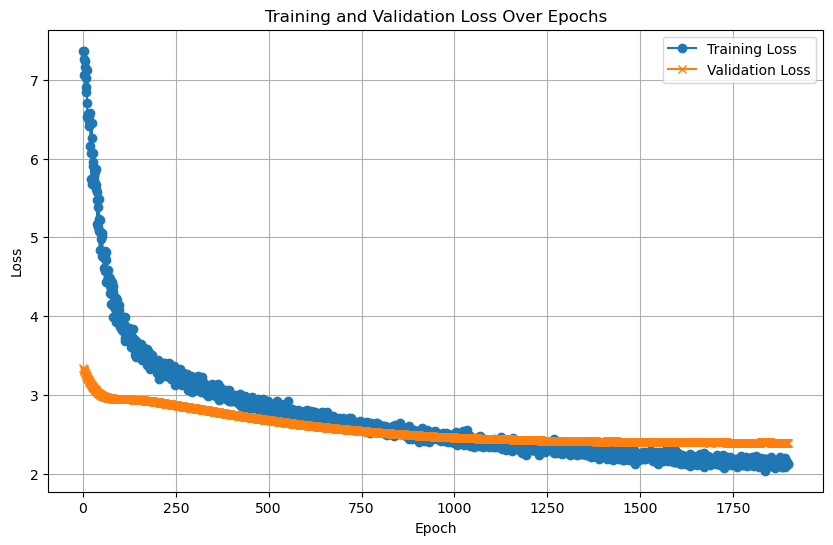

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 5.5178
Test Batch [20/211], Loss: 5.9201
Test Batch [30/211], Loss: 6.1877
Test Batch [40/211], Loss: 6.2378


Test Batch [50/211], Loss: 6.9742
Test Batch [60/211], Loss: 5.9054
Test Batch [70/211], Loss: 4.9147
Test Batch [80/211], Loss: 5.0125
Test Batch [90/211], Loss: 4.5797
Test Batch [100/211], Loss: 4.6176
Test Batch [110/211], Loss: 4.6419
Test Batch [120/211], Loss: 4.8217
Test Batch [130/211], Loss: 5.1230
Test Batch [140/211], Loss: 5.2221
Test Batch [150/211], Loss: 5.2845


Test Batch [160/211], Loss: 5.1886
Test Batch [170/211], Loss: 5.1904
Test Batch [180/211], Loss: 5.3625
Test Batch [190/211], Loss: 5.2965
Test Batch [200/211], Loss: 5.6064
Test Batch [210/211], Loss: 5.5314

Test Loss: 5.3717


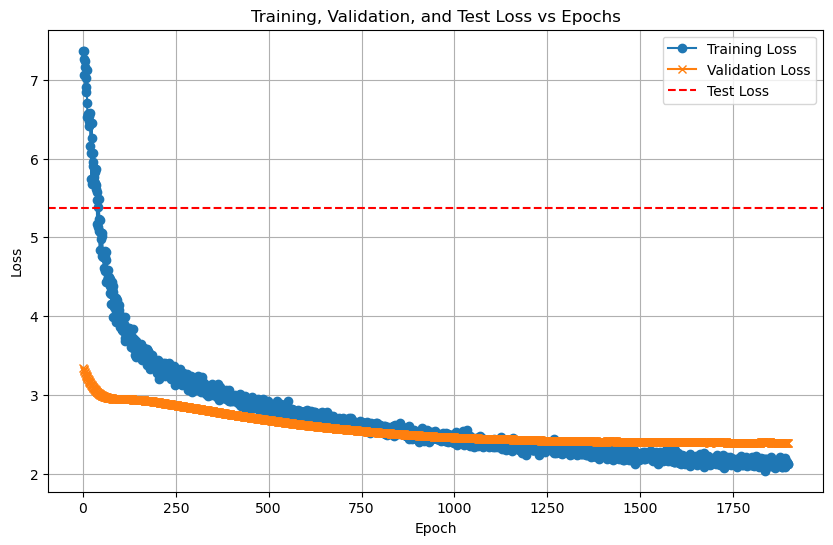

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.


  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.


  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.


  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.60      0.60      0.60         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.57      0.80      0.67         5
           8       1.00      0.80      0.89         5
           9       1.00      0.80      0.89         5
          10       0.80      0.80      0.80         5
          11       1.00      0.80      0.89         5
          12       0.83      1.00      0.91         5
          13       0.8

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9004  |  Val Loss: 2.8680
Validation loss improved from inf to 2.8680.
[Epoch 2/1000] Train Loss: 2.8785  |  Val Loss: 2.8484
Validation loss improved from 2.8680 to 2.8484.
[Epoch 3/1000] Train Loss: 2.8586  |  Val Loss: 2.8300
Validation loss improved from 2.8484 to 2.8300.
[Epoch 4/1000] Train Loss: 2.8387  |  Val Loss: 2.8124
Validation loss improved from 2.8300 to 2.8124.
[Epoch 5/1000] Train Loss: 2.8194  |  Val Loss: 2.7952
Validation loss improved from 2.8124 to 2.7952.
[Epoch 6/1000] Train Loss: 2.8003  |  Val Loss: 2.7788
Validation loss improved from 2.7952 to 2.7788.
[Epoch 7/1000] Train Loss: 2.7837  |  Val Loss: 2.7630
Validation loss improved from 2.7788 to 2.7630.
[Epoch 8/1000] Train Loss: 2.7668  |  Val Loss: 2.7481
Validation loss improved from 2.7630 to 2.7481.
[Epoch 9/1000] Train Loss: 2.7522  |  Val Loss: 2.7352
Validation loss improved from 2.7481 to 2.7352.
[Epoch 10/1000] Train Loss: 2.7381  |  Val Loss: 2.7235
Validation loss impr

[Epoch 35/1000] Train Loss: 2.4746  |  Val Loss: 2.4887
Validation loss improved from 2.4969 to 2.4887.
[Epoch 36/1000] Train Loss: 2.4659  |  Val Loss: 2.4806
Validation loss improved from 2.4887 to 2.4806.
[Epoch 37/1000] Train Loss: 2.4571  |  Val Loss: 2.4728
Validation loss improved from 2.4806 to 2.4728.
[Epoch 38/1000] Train Loss: 2.4485  |  Val Loss: 2.4651
Validation loss improved from 2.4728 to 2.4651.
[Epoch 39/1000] Train Loss: 2.4399  |  Val Loss: 2.4573
Validation loss improved from 2.4651 to 2.4573.
[Epoch 40/1000] Train Loss: 2.4317  |  Val Loss: 2.4493
Validation loss improved from 2.4573 to 2.4493.
[Epoch 41/1000] Train Loss: 2.4233  |  Val Loss: 2.4415
Validation loss improved from 2.4493 to 2.4415.
[Epoch 42/1000] Train Loss: 2.4153  |  Val Loss: 2.4338
Validation loss improved from 2.4415 to 2.4338.
[Epoch 43/1000] Train Loss: 2.4072  |  Val Loss: 2.4260
Validation loss improved from 2.4338 to 2.4260.
[Epoch 44/1000] Train Loss: 2.3995  |  Val Loss: 2.4183
Validati

[Epoch 75/1000] Train Loss: 2.1352  |  Val Loss: 2.1765
Validation loss improved from 2.1849 to 2.1765.
[Epoch 76/1000] Train Loss: 2.1263  |  Val Loss: 2.1682
Validation loss improved from 2.1765 to 2.1682.
[Epoch 77/1000] Train Loss: 2.1170  |  Val Loss: 2.1599
Validation loss improved from 2.1682 to 2.1599.
[Epoch 78/1000] Train Loss: 2.1078  |  Val Loss: 2.1516
Validation loss improved from 2.1599 to 2.1516.
[Epoch 79/1000] Train Loss: 2.0987  |  Val Loss: 2.1434
Validation loss improved from 2.1516 to 2.1434.
[Epoch 80/1000] Train Loss: 2.0896  |  Val Loss: 2.1352
Validation loss improved from 2.1434 to 2.1352.
[Epoch 81/1000] Train Loss: 2.0804  |  Val Loss: 2.1268
Validation loss improved from 2.1352 to 2.1268.
[Epoch 82/1000] Train Loss: 2.0710  |  Val Loss: 2.1183
Validation loss improved from 2.1268 to 2.1183.
[Epoch 83/1000] Train Loss: 2.0619  |  Val Loss: 2.1097
Validation loss improved from 2.1183 to 2.1097.
[Epoch 84/1000] Train Loss: 2.0520  |  Val Loss: 2.1010
Validati

[Epoch 112/1000] Train Loss: 1.7732  |  Val Loss: 1.8434
Validation loss improved from 1.8527 to 1.8434.
[Epoch 113/1000] Train Loss: 1.7629  |  Val Loss: 1.8337
Validation loss improved from 1.8434 to 1.8337.
[Epoch 114/1000] Train Loss: 1.7526  |  Val Loss: 1.8241
Validation loss improved from 1.8337 to 1.8241.
[Epoch 115/1000] Train Loss: 1.7424  |  Val Loss: 1.8145
Validation loss improved from 1.8241 to 1.8145.
[Epoch 116/1000] Train Loss: 1.7323  |  Val Loss: 1.8051
Validation loss improved from 1.8145 to 1.8051.
[Epoch 117/1000] Train Loss: 1.7219  |  Val Loss: 1.7957
Validation loss improved from 1.8051 to 1.7957.
[Epoch 118/1000] Train Loss: 1.7120  |  Val Loss: 1.7861
Validation loss improved from 1.7957 to 1.7861.
[Epoch 119/1000] Train Loss: 1.7015  |  Val Loss: 1.7765
Validation loss improved from 1.7861 to 1.7765.
[Epoch 120/1000] Train Loss: 1.6909  |  Val Loss: 1.7668
Validation loss improved from 1.7765 to 1.7668.
[Epoch 121/1000] Train Loss: 1.6802  |  Val Loss: 1.757

[Epoch 152/1000] Train Loss: 1.3362  |  Val Loss: 1.4481
Validation loss improved from 1.4575 to 1.4481.
[Epoch 153/1000] Train Loss: 1.3256  |  Val Loss: 1.4387
Validation loss improved from 1.4481 to 1.4387.
[Epoch 154/1000] Train Loss: 1.3150  |  Val Loss: 1.4294
Validation loss improved from 1.4387 to 1.4294.
[Epoch 155/1000] Train Loss: 1.3042  |  Val Loss: 1.4200
Validation loss improved from 1.4294 to 1.4200.
[Epoch 156/1000] Train Loss: 1.2937  |  Val Loss: 1.4104
Validation loss improved from 1.4200 to 1.4104.
[Epoch 157/1000] Train Loss: 1.2831  |  Val Loss: 1.4010
Validation loss improved from 1.4104 to 1.4010.
[Epoch 158/1000] Train Loss: 1.2728  |  Val Loss: 1.3917
Validation loss improved from 1.4010 to 1.3917.
[Epoch 159/1000] Train Loss: 1.2624  |  Val Loss: 1.3825
Validation loss improved from 1.3917 to 1.3825.
[Epoch 160/1000] Train Loss: 1.2523  |  Val Loss: 1.3734
Validation loss improved from 1.3825 to 1.3734.
[Epoch 161/1000] Train Loss: 1.2419  |  Val Loss: 1.364

[Epoch 193/1000] Train Loss: 0.9486  |  Val Loss: 1.1104
Validation loss improved from 1.1169 to 1.1104.
[Epoch 194/1000] Train Loss: 0.9410  |  Val Loss: 1.1041
Validation loss improved from 1.1104 to 1.1041.
[Epoch 195/1000] Train Loss: 0.9330  |  Val Loss: 1.0976
Validation loss improved from 1.1041 to 1.0976.
[Epoch 196/1000] Train Loss: 0.9254  |  Val Loss: 1.0909
Validation loss improved from 1.0976 to 1.0909.
[Epoch 197/1000] Train Loss: 0.9175  |  Val Loss: 1.0841
Validation loss improved from 1.0909 to 1.0841.
[Epoch 198/1000] Train Loss: 0.9101  |  Val Loss: 1.0775
Validation loss improved from 1.0841 to 1.0775.
[Epoch 199/1000] Train Loss: 0.9023  |  Val Loss: 1.0711
Validation loss improved from 1.0775 to 1.0711.
[Epoch 200/1000] Train Loss: 0.8951  |  Val Loss: 1.0647
Validation loss improved from 1.0711 to 1.0647.
[Epoch 201/1000] Train Loss: 0.8883  |  Val Loss: 1.0587
Validation loss improved from 1.0647 to 1.0587.
[Epoch 202/1000] Train Loss: 0.8807  |  Val Loss: 1.052

[Epoch 233/1000] Train Loss: 0.6840  |  Val Loss: 0.8884
Validation loss improved from 0.8931 to 0.8884.
[Epoch 234/1000] Train Loss: 0.6789  |  Val Loss: 0.8836
Validation loss improved from 0.8884 to 0.8836.
[Epoch 235/1000] Train Loss: 0.6735  |  Val Loss: 0.8789
Validation loss improved from 0.8836 to 0.8789.
[Epoch 236/1000] Train Loss: 0.6678  |  Val Loss: 0.8743
Validation loss improved from 0.8789 to 0.8743.
[Epoch 237/1000] Train Loss: 0.6627  |  Val Loss: 0.8699
Validation loss improved from 0.8743 to 0.8699.
[Epoch 238/1000] Train Loss: 0.6572  |  Val Loss: 0.8655
Validation loss improved from 0.8699 to 0.8655.
[Epoch 239/1000] Train Loss: 0.6522  |  Val Loss: 0.8611
Validation loss improved from 0.8655 to 0.8611.
[Epoch 240/1000] Train Loss: 0.6469  |  Val Loss: 0.8567
Validation loss improved from 0.8611 to 0.8567.
[Epoch 241/1000] Train Loss: 0.6414  |  Val Loss: 0.8523
Validation loss improved from 0.8567 to 0.8523.
[Epoch 242/1000] Train Loss: 0.6364  |  Val Loss: 0.848

[Epoch 273/1000] Train Loss: 0.5018  |  Val Loss: 0.7360
Validation loss improved from 0.7397 to 0.7360.
[Epoch 274/1000] Train Loss: 0.4981  |  Val Loss: 0.7324
Validation loss improved from 0.7360 to 0.7324.
[Epoch 275/1000] Train Loss: 0.4943  |  Val Loss: 0.7290
Validation loss improved from 0.7324 to 0.7290.
[Epoch 276/1000] Train Loss: 0.4906  |  Val Loss: 0.7258
Validation loss improved from 0.7290 to 0.7258.
[Epoch 277/1000] Train Loss: 0.4868  |  Val Loss: 0.7229
Validation loss improved from 0.7258 to 0.7229.
[Epoch 278/1000] Train Loss: 0.4829  |  Val Loss: 0.7202
Validation loss improved from 0.7229 to 0.7202.
[Epoch 279/1000] Train Loss: 0.4791  |  Val Loss: 0.7176
Validation loss improved from 0.7202 to 0.7176.
[Epoch 280/1000] Train Loss: 0.4753  |  Val Loss: 0.7150
Validation loss improved from 0.7176 to 0.7150.
[Epoch 281/1000] Train Loss: 0.4719  |  Val Loss: 0.7125
Validation loss improved from 0.7150 to 0.7125.
[Epoch 282/1000] Train Loss: 0.4681  |  Val Loss: 0.710

[Epoch 311/1000] Train Loss: 0.3771  |  Val Loss: 0.6385
Validation loss improved from 0.6403 to 0.6385.
[Epoch 312/1000] Train Loss: 0.3743  |  Val Loss: 0.6365
Validation loss improved from 0.6385 to 0.6365.
[Epoch 313/1000] Train Loss: 0.3721  |  Val Loss: 0.6344
Validation loss improved from 0.6365 to 0.6344.
[Epoch 314/1000] Train Loss: 0.3693  |  Val Loss: 0.6325
Validation loss improved from 0.6344 to 0.6325.
[Epoch 315/1000] Train Loss: 0.3666  |  Val Loss: 0.6305
Validation loss improved from 0.6325 to 0.6305.
[Epoch 316/1000] Train Loss: 0.3642  |  Val Loss: 0.6283
Validation loss improved from 0.6305 to 0.6283.
[Epoch 317/1000] Train Loss: 0.3619  |  Val Loss: 0.6261
Validation loss improved from 0.6283 to 0.6261.
[Epoch 318/1000] Train Loss: 0.3592  |  Val Loss: 0.6239
Validation loss improved from 0.6261 to 0.6239.
[Epoch 319/1000] Train Loss: 0.3564  |  Val Loss: 0.6218
Validation loss improved from 0.6239 to 0.6218.
[Epoch 320/1000] Train Loss: 0.3539  |  Val Loss: 0.619

[Epoch 349/1000] Train Loss: 0.2917  |  Val Loss: 0.5702
Validation loss improved from 0.5712 to 0.5702.
[Epoch 350/1000] Train Loss: 0.2897  |  Val Loss: 0.5689
Validation loss improved from 0.5702 to 0.5689.
[Epoch 351/1000] Train Loss: 0.2878  |  Val Loss: 0.5674
Validation loss improved from 0.5689 to 0.5674.
[Epoch 352/1000] Train Loss: 0.2858  |  Val Loss: 0.5659
Validation loss improved from 0.5674 to 0.5659.
[Epoch 353/1000] Train Loss: 0.2839  |  Val Loss: 0.5641
Validation loss improved from 0.5659 to 0.5641.
[Epoch 354/1000] Train Loss: 0.2823  |  Val Loss: 0.5622
Validation loss improved from 0.5641 to 0.5622.
[Epoch 355/1000] Train Loss: 0.2802  |  Val Loss: 0.5604
Validation loss improved from 0.5622 to 0.5604.
[Epoch 356/1000] Train Loss: 0.2785  |  Val Loss: 0.5585
Validation loss improved from 0.5604 to 0.5585.
[Epoch 357/1000] Train Loss: 0.2767  |  Val Loss: 0.5567
Validation loss improved from 0.5585 to 0.5567.
[Epoch 358/1000] Train Loss: 0.2748  |  Val Loss: 0.554

[Epoch 391/1000] Train Loss: 0.2257  |  Val Loss: 0.5165
Validation loss improved from 0.5176 to 0.5165.
[Epoch 392/1000] Train Loss: 0.2244  |  Val Loss: 0.5156
Validation loss improved from 0.5165 to 0.5156.
[Epoch 393/1000] Train Loss: 0.2230  |  Val Loss: 0.5147
Validation loss improved from 0.5156 to 0.5147.
[Epoch 394/1000] Train Loss: 0.2217  |  Val Loss: 0.5137
Validation loss improved from 0.5147 to 0.5137.
[Epoch 395/1000] Train Loss: 0.2208  |  Val Loss: 0.5131
Validation loss improved from 0.5137 to 0.5131.
[Epoch 396/1000] Train Loss: 0.2198  |  Val Loss: 0.5127
Validation loss improved from 0.5131 to 0.5127.
[Epoch 397/1000] Train Loss: 0.2186  |  Val Loss: 0.5123
Validation loss improved from 0.5127 to 0.5123.
[Epoch 398/1000] Train Loss: 0.2173  |  Val Loss: 0.5117
Validation loss improved from 0.5123 to 0.5117.
[Epoch 399/1000] Train Loss: 0.2162  |  Val Loss: 0.5110
Validation loss improved from 0.5117 to 0.5110.
[Epoch 400/1000] Train Loss: 0.2150  |  Val Loss: 0.510

[Epoch 433/1000] Train Loss: 0.1823  |  Val Loss: 0.4951
Validation loss improved from 0.4957 to 0.4951.
[Epoch 434/1000] Train Loss: 0.1814  |  Val Loss: 0.4944
Validation loss improved from 0.4951 to 0.4944.
[Epoch 435/1000] Train Loss: 0.1805  |  Val Loss: 0.4936
Validation loss improved from 0.4944 to 0.4936.
[Epoch 436/1000] Train Loss: 0.1797  |  Val Loss: 0.4927
Validation loss improved from 0.4936 to 0.4927.
[Epoch 437/1000] Train Loss: 0.1787  |  Val Loss: 0.4918
Validation loss improved from 0.4927 to 0.4918.
[Epoch 438/1000] Train Loss: 0.1780  |  Val Loss: 0.4909
Validation loss improved from 0.4918 to 0.4909.
[Epoch 439/1000] Train Loss: 0.1771  |  Val Loss: 0.4901
Validation loss improved from 0.4909 to 0.4901.
[Epoch 440/1000] Train Loss: 0.1771  |  Val Loss: 0.4892
Validation loss improved from 0.4901 to 0.4892.
[Epoch 441/1000] Train Loss: 0.1759  |  Val Loss: 0.4882
Validation loss improved from 0.4892 to 0.4882.
[Epoch 442/1000] Train Loss: 0.1752  |  Val Loss: 0.487

[Epoch 476/1000] Train Loss: 0.1530  |  Val Loss: 0.4747
Validation loss improved from 0.4751 to 0.4747.
[Epoch 477/1000] Train Loss: 0.1524  |  Val Loss: 0.4742
Validation loss improved from 0.4747 to 0.4742.
[Epoch 478/1000] Train Loss: 0.1517  |  Val Loss: 0.4739
Validation loss improved from 0.4742 to 0.4739.
[Epoch 479/1000] Train Loss: 0.1510  |  Val Loss: 0.4738
Validation loss improved from 0.4739 to 0.4738.
[Epoch 480/1000] Train Loss: 0.1504  |  Val Loss: 0.4737
Validation loss improved from 0.4738 to 0.4737.
[Epoch 481/1000] Train Loss: 0.1499  |  Val Loss: 0.4736
Validation loss improved from 0.4737 to 0.4736.
[Epoch 482/1000] Train Loss: 0.1492  |  Val Loss: 0.4733
Validation loss improved from 0.4736 to 0.4733.
[Epoch 483/1000] Train Loss: 0.1487  |  Val Loss: 0.4731
Validation loss improved from 0.4733 to 0.4731.
[Epoch 484/1000] Train Loss: 0.1482  |  Val Loss: 0.4728
Validation loss improved from 0.4731 to 0.4728.
[Epoch 485/1000] Train Loss: 0.1477  |  Val Loss: 0.472

[Epoch 516/1000] Train Loss: 0.1332  |  Val Loss: 0.4658
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 517/1000] Train Loss: 0.1329  |  Val Loss: 0.4658
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 518/1000] Train Loss: 0.1323  |  Val Loss: 0.4657
Validation loss improved from 0.4658 to 0.4657.
[Epoch 519/1000] Train Loss: 0.1316  |  Val Loss: 0.4656
Validation loss improved from 0.4657 to 0.4656.
[Epoch 520/1000] Train Loss: 0.1309  |  Val Loss: 0.4655
Validation loss improved from 0.4656 to 0.4655.
[Epoch 521/1000] Train Loss: 0.1304  |  Val Loss: 0.4653
Validation loss improved from 0.4655 to 0.4653.
[Epoch 522/1000] Train Loss: 0.1300  |  Val Loss: 0.4652
Validation loss improved from 0.4653 to 0.4652.
[Epoch 523/1000] Train Loss: 0.1299  |  Val Loss: 0.4650
Validation loss improved from 0.4652 to 0.4650.
[Epoch 524/1000] Train Loss: 0.1299  |  Val Loss: 0.4648
Validation loss improved from 0.4650 to 0.4648.
[Epoch 525/1000] Train Loss: 0.1293  |  Val

[Epoch 557/1000] Train Loss: 0.1185  |  Val Loss: 0.4603
Validation loss improved from 0.4604 to 0.4603.
[Epoch 558/1000] Train Loss: 0.1182  |  Val Loss: 0.4601
Validation loss improved from 0.4603 to 0.4601.
[Epoch 559/1000] Train Loss: 0.1178  |  Val Loss: 0.4597
Validation loss improved from 0.4601 to 0.4597.
[Epoch 560/1000] Train Loss: 0.1174  |  Val Loss: 0.4595
Validation loss improved from 0.4597 to 0.4595.
[Epoch 561/1000] Train Loss: 0.1170  |  Val Loss: 0.4591
Validation loss improved from 0.4595 to 0.4591.
[Epoch 562/1000] Train Loss: 0.1166  |  Val Loss: 0.4586
Validation loss improved from 0.4591 to 0.4586.
[Epoch 563/1000] Train Loss: 0.1163  |  Val Loss: 0.4582
Validation loss improved from 0.4586 to 0.4582.
[Epoch 564/1000] Train Loss: 0.1157  |  Val Loss: 0.4579
Validation loss improved from 0.4582 to 0.4579.
[Epoch 565/1000] Train Loss: 0.1154  |  Val Loss: 0.4579
Validation loss improved from 0.4579 to 0.4579.
[Epoch 566/1000] Train Loss: 0.1151  |  Val Loss: 0.457

[Epoch 598/1000] Train Loss: 0.1063  |  Val Loss: 0.4559
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 599/1000] Train Loss: 0.1061  |  Val Loss: 0.4558
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 600/1000] Train Loss: 0.1059  |  Val Loss: 0.4556
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 601/1000] Train Loss: 0.1056  |  Val Loss: 0.4553
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 602/1000] Train Loss: 0.1056  |  Val Loss: 0.4551
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 603/1000] Train Loss: 0.1053  |  Val Loss: 0.4549
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 604/1000] Train Loss: 0.1049  |  Val Loss: 0.4548
Validation loss improved from 0.4549 to 0.4548.
[Epoch 605/1000] Train Loss: 0.1047  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 606/1000] Train Loss: 0.1045  |  Val Loss: 0.4549
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 637/1000] Train Loss: 0.0979  |  Val Loss: 0.4550
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 638/1000] Train Loss: 0.0978  |  Val Loss: 0.4550
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 639/1000] Train Loss: 0.0979  |  Val Loss: 0.4550
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 640/1000] Train Loss: 0.0975  |  Val Loss: 0.4549
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 641/1000] Train Loss: 0.0973  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 642/1000] Train Loss: 0.0972  |  Val Loss: 0.4547
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 643/1000] Train Loss: 0.0967  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 644/1000] Train Loss: 0.0964  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 645/1000] Train Loss: 0.0962  |  Val Loss: 0.4547
!! Validation loss did NOT improve !! Patience:

[Epoch 679/1000] Train Loss: 0.0905  |  Val Loss: 0.4581
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 680/1000] Train Loss: 0.0904  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 681/1000] Train Loss: 0.0902  |  Val Loss: 0.4581
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 682/1000] Train Loss: 0.0900  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 683/1000] Train Loss: 0.0899  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 684/1000] Train Loss: 0.0897  |  Val Loss: 0.4581
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 685/1000] Train Loss: 0.0896  |  Val Loss: 0.4580
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 686/1000] Train Loss: 0.0893  |  Val Loss: 0.4578
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 687/1000] Train Loss: 0.0892  |  Val Loss: 0.4577
!! Validation loss did NOT improve !! Patience:

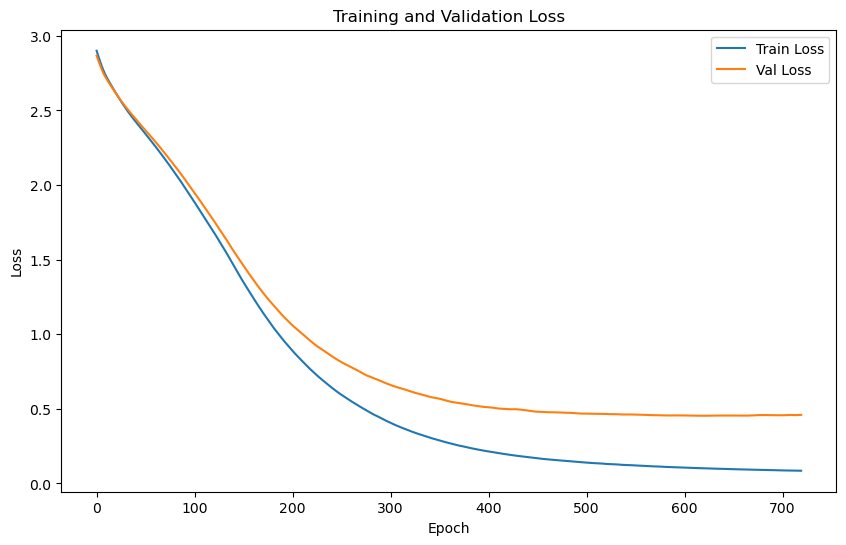

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7737 | Test Accuracy: 79.97%


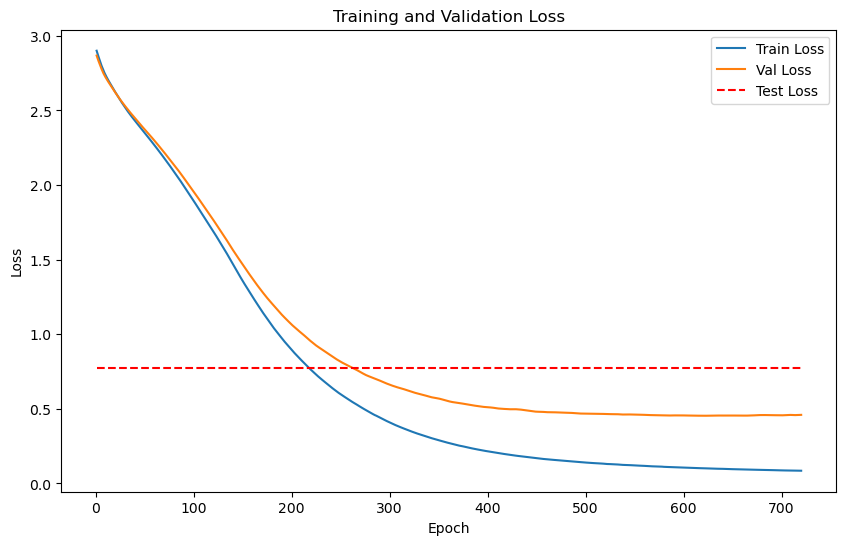

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.3234
Epoch [1/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3224

Validation loss improved from inf to 0.3224. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3229
    Batch [2/2], Val Loss: 0.3232
Epoch [2/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3240
    Batch [2/2], Val Loss: 0.3230
Epoch [3/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3252
    Batch [2/2], Val Loss: 0.3234
Epoch [4/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.3241
Epoch [5/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3285
    Batch [2/2], Val Loss: 0.3246
Epoch [6/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3299
    Batch [2/2], Val Loss: 0.3253
Epoch [7/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3276

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3306
    Batch [2/2], Val Loss: 0.3259
Epoch [8/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3310
    Batch [2/2], Val Loss: 0.3260
Epoch [9/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.3285

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3318
    Batch [2/2], Val Loss: 0.3263
Epoch [10/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3333
    Batch [2/2], Val Loss: 0.3269
Epoch [11/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3301

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.3279
Epoch [12/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.3288
Epoch [13/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.3296
Epoch [14/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.3306
Epoch [15/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.3316
Epoch [16/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3358

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3407
    Batch [2/2], Val Loss: 0.3328
Epoch [17/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3367

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.3340
Epoch [18/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3377

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3418
    Batch [2/2], Val Loss: 0.3354
Epoch [19/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3421
    Batch [2/2], Val Loss: 0.3365
Epoch [20/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3424
    Batch [2/2], Val Loss: 0.3374
Epoch [21/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3425
    Batch [2/2], Val Loss: 0.3381
Epoch [22/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3425
    Batch [2/2], Val Loss: 0.3388
Epoch [23/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3424
    Batch [2/2], Val Loss: 0.3393
Epoch [24/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3408

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.3400
Epoch [25/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.3407
Epoch [26/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3416
    Batch [2/2], Val Loss: 0.3412
Epoch [27/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3414

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.3416
Epoch [28/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3416

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.3419
Epoch [29/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3416
    Batch [2/2], Val Loss: 0.3422
Epoch [30/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3415
    Batch [2/2], Val Loss: 0.3425
Epoch [31/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.3430
Epoch [32/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.3437
Epoch [33/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3410
    Batch [2/2], Val Loss: 0.3443
Epoch [34/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3408
    Batch [2/2], Val Loss: 0.3450
Epoch [35/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3429

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.3457
Epoch [36/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3431

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.3463
Epoch [37/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3434

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.3469
Epoch [38/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3401
    Batch [2/2], Val Loss: 0.3475
Epoch [39/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.3481
Epoch [40/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.3486
Epoch [41/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.3491
Epoch [42/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.3496
Epoch [43/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.3501
Epoch [44/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.3506
Epoch [45/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3449

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.3510
Epoch [46/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.3514
Epoch [47/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.3518
Epoch [48/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3453

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3388
    Batch [2/2], Val Loss: 0.3521
Epoch [49/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3455

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.3524
Epoch [50/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3456

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.3527
Epoch [51/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3457

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3385
    Batch [2/2], Val Loss: 0.3530
Epoch [52/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3458

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.3532
Epoch [53/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3458

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.3535
Epoch [54/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3459

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.3537
Epoch [55/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3460

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.3539
Epoch [56/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3461

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.3540
Epoch [57/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3461

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.3542
Epoch [58/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.3543
Epoch [59/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.3545
Epoch [60/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.3546
Epoch [61/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3547
Epoch [62/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3548
Epoch [63/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3465

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3549
Epoch [64/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3465

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3550
Epoch [65/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3465

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.3551
Epoch [66/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3466

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3551
Epoch [67/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3466

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3552
Epoch [68/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3466

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3552
Epoch [69/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3466

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3553
Epoch [70/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3466

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3553
Epoch [71/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3554
Epoch [72/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3554
Epoch [73/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3554
Epoch [74/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3555
Epoch [75/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3555
Epoch [76/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3555
Epoch [77/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [78/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [79/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [80/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3467

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [81/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [82/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [83/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3556
Epoch [84/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [85/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [86/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [87/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [88/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [89/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [90/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [91/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [92/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [93/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [94/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [95/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [96/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [97/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [98/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [99/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [100/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3557
Epoch [101/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3468

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 101!!
No improvement for 100 epochs


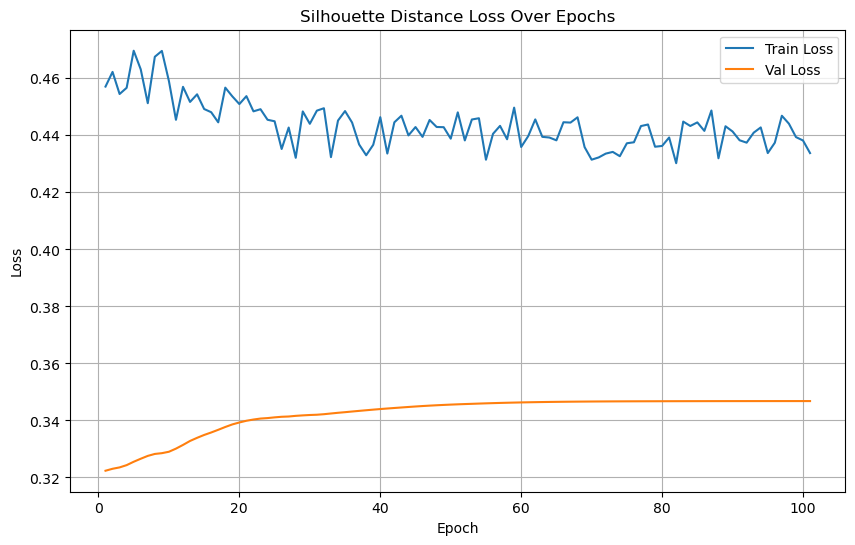

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/844], Loss: 0.1608


Test Batch [20/844], Loss: 0.1883
Test Batch [30/844], Loss: 0.2132
Test Batch [40/844], Loss: 0.1535
Test Batch [50/844], Loss: 0.1466
Test Batch [60/844], Loss: 0.5000
Test Batch [70/844], Loss: 0.1646
Test Batch [80/844], Loss: 0.2030


Test Batch [90/844], Loss: 0.5000
Test Batch [100/844], Loss: 0.2905
Test Batch [110/844], Loss: 0.2207
Test Batch [120/844], Loss: 0.2006
Test Batch [130/844], Loss: 0.5000
Test Batch [140/844], Loss: 0.5000
Test Batch [150/844], Loss: 0.2471
Test Batch [160/844], Loss: 0.3542


Test Batch [170/844], Loss: 0.2938
Test Batch [180/844], Loss: 0.2488
Test Batch [190/844], Loss: 0.1817
Test Batch [200/844], Loss: 0.1289
Test Batch [210/844], Loss: 0.1286


Test Batch [220/844], Loss: 0.1141
Test Batch [230/844], Loss: 0.1918
Test Batch [240/844], Loss: 0.1888
Test Batch [250/844], Loss: 0.2522


Test Batch [260/844], Loss: 0.3622
Test Batch [270/844], Loss: 0.3324
Test Batch [280/844], Loss: 0.3511
Test Batch [290/844], Loss: 0.3551


Test Batch [300/844], Loss: 0.3769
Test Batch [310/844], Loss: 0.3316
Test Batch [320/844], Loss: 0.2021
Test Batch [330/844], Loss: 0.3088
Test Batch [340/844], Loss: 0.2930
Test Batch [350/844], Loss: 0.5000


Test Batch [360/844], Loss: 0.1823
Test Batch [370/844], Loss: 0.5000
Test Batch [380/844], Loss: 0.5000
Test Batch [390/844], Loss: 0.5000
Test Batch [400/844], Loss: 0.5000
Test Batch [410/844], Loss: 0.5000
Test Batch [420/844], Loss: 0.5000
Test Batch [430/844], Loss: 0.0748
Test Batch [440/844], Loss: 0.0885
Test Batch [450/844], Loss: 0.2181


Test Batch [460/844], Loss: 0.1093
Test Batch [470/844], Loss: 0.1435
Test Batch [480/844], Loss: 0.2160
Test Batch [490/844], Loss: 0.5000
Test Batch [500/844], Loss: 0.2057
Test Batch [510/844], Loss: 0.2324
Test Batch [520/844], Loss: 0.1625
Test Batch [530/844], Loss: 0.1307


Test Batch [540/844], Loss: 0.2208
Test Batch [550/844], Loss: 0.1327
Test Batch [560/844], Loss: 0.1551
Test Batch [570/844], Loss: 0.1520
Test Batch [580/844], Loss: 0.2158


Test Batch [590/844], Loss: 0.2200
Test Batch [600/844], Loss: 0.1602
Test Batch [610/844], Loss: 0.2285
Test Batch [620/844], Loss: 0.2645
Test Batch [630/844], Loss: 0.3581


Test Batch [640/844], Loss: 0.2501
Test Batch [650/844], Loss: 0.1679
Test Batch [660/844], Loss: 0.1339
Test Batch [670/844], Loss: 0.1982
Test Batch [680/844], Loss: 0.1843


Test Batch [690/844], Loss: 0.1452
Test Batch [700/844], Loss: 0.3434
Test Batch [710/844], Loss: 0.1781
Test Batch [720/844], Loss: 0.4290
Test Batch [730/844], Loss: 0.1758


Test Batch [740/844], Loss: 0.2142
Test Batch [750/844], Loss: 0.2278
Test Batch [760/844], Loss: 0.2134
Test Batch [770/844], Loss: 0.5000
Test Batch [780/844], Loss: 0.2696


Test Batch [790/844], Loss: 0.2478
Test Batch [800/844], Loss: 0.3811
Test Batch [810/844], Loss: 0.1671
Test Batch [820/844], Loss: 0.1745
Test Batch [830/844], Loss: 0.1552
Test Batch [840/844], Loss: 0.2206

Test Loss: 0.2712


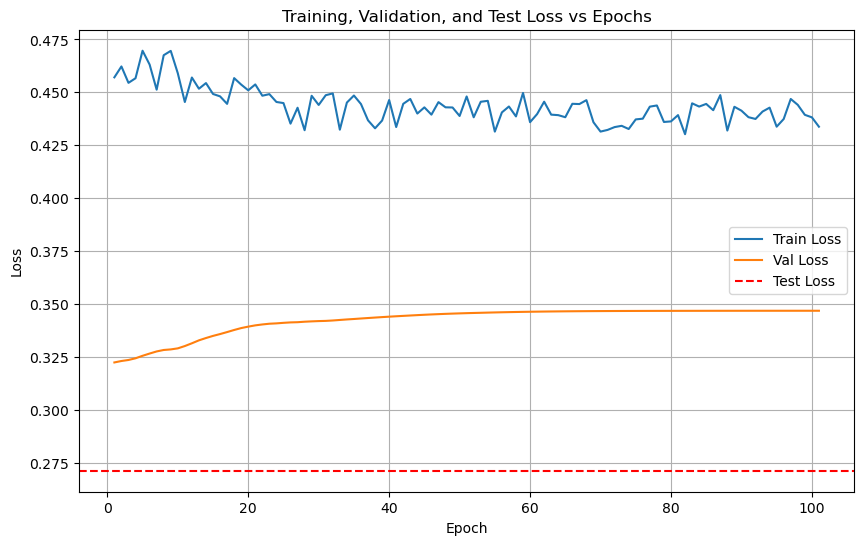

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/844 for test dataset.
  Processed batch 20/844 for test dataset.
  Processed batch 30/844 for test dataset.


  Processed batch 40/844 for test dataset.
  Processed batch 50/844 for test dataset.
  Processed batch 60/844 for test dataset.
  Processed batch 70/844 for test dataset.


  Processed batch 80/844 for test dataset.
  Processed batch 90/844 for test dataset.
  Processed batch 100/844 for test dataset.


  Processed batch 110/844 for test dataset.
  Processed batch 120/844 for test dataset.
  Processed batch 130/844 for test dataset.


  Processed batch 140/844 for test dataset.
  Processed batch 150/844 for test dataset.
  Processed batch 160/844 for test dataset.


  Processed batch 170/844 for test dataset.
  Processed batch 180/844 for test dataset.
  Processed batch 190/844 for test dataset.


  Processed batch 200/844 for test dataset.
  Processed batch 210/844 for test dataset.
  Processed batch 220/844 for test dataset.


  Processed batch 230/844 for test dataset.
  Processed batch 240/844 for test dataset.
  Processed batch 250/844 for test dataset.


  Processed batch 260/844 for test dataset.
  Processed batch 270/844 for test dataset.
  Processed batch 280/844 for test dataset.
  Processed batch 290/844 for test dataset.


  Processed batch 300/844 for test dataset.
  Processed batch 310/844 for test dataset.
  Processed batch 320/844 for test dataset.
  Processed batch 330/844 for test dataset.


  Processed batch 340/844 for test dataset.
  Processed batch 350/844 for test dataset.
  Processed batch 360/844 for test dataset.


  Processed batch 370/844 for test dataset.
  Processed batch 380/844 for test dataset.
  Processed batch 390/844 for test dataset.
  Processed batch 400/844 for test dataset.


  Processed batch 410/844 for test dataset.
  Processed batch 420/844 for test dataset.
  Processed batch 430/844 for test dataset.


  Processed batch 440/844 for test dataset.
  Processed batch 450/844 for test dataset.
  Processed batch 460/844 for test dataset.


  Processed batch 470/844 for test dataset.
  Processed batch 480/844 for test dataset.
  Processed batch 490/844 for test dataset.


  Processed batch 500/844 for test dataset.
  Processed batch 510/844 for test dataset.
  Processed batch 520/844 for test dataset.


  Processed batch 530/844 for test dataset.
  Processed batch 540/844 for test dataset.
  Processed batch 550/844 for test dataset.
  Processed batch 560/844 for test dataset.


  Processed batch 570/844 for test dataset.
  Processed batch 580/844 for test dataset.
  Processed batch 590/844 for test dataset.


  Processed batch 600/844 for test dataset.
  Processed batch 610/844 for test dataset.
  Processed batch 620/844 for test dataset.
  Processed batch 630/844 for test dataset.


  Processed batch 640/844 for test dataset.
  Processed batch 650/844 for test dataset.
  Processed batch 660/844 for test dataset.
  Processed batch 670/844 for test dataset.


  Processed batch 680/844 for test dataset.
  Processed batch 690/844 for test dataset.
  Processed batch 700/844 for test dataset.


  Processed batch 710/844 for test dataset.
  Processed batch 720/844 for test dataset.
  Processed batch 730/844 for test dataset.
  Processed batch 740/844 for test dataset.


  Processed batch 750/844 for test dataset.
  Processed batch 760/844 for test dataset.
  Processed batch 770/844 for test dataset.


  Processed batch 780/844 for test dataset.
  Processed batch 790/844 for test dataset.
  Processed batch 800/844 for test dataset.


  Processed batch 810/844 for test dataset.
  Processed batch 820/844 for test dataset.
  Processed batch 830/844 for test dataset.
  Processed batch 840/844 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.71      1.00      0.83         5
           9       1.00      1.00      1.00         5
          10       1.00      0.60      0.75         5
          11       1.00      0.60      0.75         5
          12       0.71      1.00      0.83         5
          13       0.8

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7693  |  Val Loss: 2.7678
Validation loss improved from inf to 2.7678.
[Epoch 2/1000] Train Loss: 2.7610  |  Val Loss: 2.7608
Validation loss improved from 2.7678 to 2.7608.
[Epoch 3/1000] Train Loss: 2.7533  |  Val Loss: 2.7541
Validation loss improved from 2.7608 to 2.7541.
[Epoch 4/1000] Train Loss: 2.7459  |  Val Loss: 2.7475
Validation loss improved from 2.7541 to 2.7475.
[Epoch 5/1000] Train Loss: 2.7388  |  Val Loss: 2.7411
Validation loss improved from 2.7475 to 2.7411.
[Epoch 6/1000] Train Loss: 2.7320  |  Val Loss: 2.7347
Validation loss improved from 2.7411 to 2.7347.
[Epoch 7/1000] Train Loss: 2.7254  |  Val Loss: 2.7287
Validation loss improved from 2.7347 to 2.7287.
[Epoch 8/1000] Train Loss: 2.7187  |  Val Loss: 2.7228
Validation loss improved from 2.7287 to 2.7228.
[Epoch 9/1000] Train Loss: 2.7122  |  Val Loss: 2.7170
Validation loss improved from 2.7228 to 2.7170.
[Epoch 10/1000] Train Loss: 2.7060  |  Val Loss: 2.7113
Validation loss impr

[Epoch 34/1000] Train Loss: 2.5670  |  Val Loss: 2.5827
Validation loss improved from 2.5882 to 2.5827.


[Epoch 35/1000] Train Loss: 2.5611  |  Val Loss: 2.5773
Validation loss improved from 2.5827 to 2.5773.
[Epoch 36/1000] Train Loss: 2.5556  |  Val Loss: 2.5719
Validation loss improved from 2.5773 to 2.5719.
[Epoch 37/1000] Train Loss: 2.5500  |  Val Loss: 2.5665
Validation loss improved from 2.5719 to 2.5665.
[Epoch 38/1000] Train Loss: 2.5442  |  Val Loss: 2.5611
Validation loss improved from 2.5665 to 2.5611.
[Epoch 39/1000] Train Loss: 2.5386  |  Val Loss: 2.5558
Validation loss improved from 2.5611 to 2.5558.
[Epoch 40/1000] Train Loss: 2.5328  |  Val Loss: 2.5508
Validation loss improved from 2.5558 to 2.5508.
[Epoch 41/1000] Train Loss: 2.5272  |  Val Loss: 2.5457
Validation loss improved from 2.5508 to 2.5457.
[Epoch 42/1000] Train Loss: 2.5217  |  Val Loss: 2.5408
Validation loss improved from 2.5457 to 2.5408.
[Epoch 43/1000] Train Loss: 2.5161  |  Val Loss: 2.5358
Validation loss improved from 2.5408 to 2.5358.
[Epoch 44/1000] Train Loss: 2.5106  |  Val Loss: 2.5309
Validati

[Epoch 76/1000] Train Loss: 2.3087  |  Val Loss: 2.3506
Validation loss improved from 2.3562 to 2.3506.
[Epoch 77/1000] Train Loss: 2.3023  |  Val Loss: 2.3450
Validation loss improved from 2.3506 to 2.3450.
[Epoch 78/1000] Train Loss: 2.2957  |  Val Loss: 2.3394
Validation loss improved from 2.3450 to 2.3394.
[Epoch 79/1000] Train Loss: 2.2892  |  Val Loss: 2.3338
Validation loss improved from 2.3394 to 2.3338.
[Epoch 80/1000] Train Loss: 2.2829  |  Val Loss: 2.3282
Validation loss improved from 2.3338 to 2.3282.
[Epoch 81/1000] Train Loss: 2.2763  |  Val Loss: 2.3225
Validation loss improved from 2.3282 to 2.3225.
[Epoch 82/1000] Train Loss: 2.2697  |  Val Loss: 2.3168
Validation loss improved from 2.3225 to 2.3168.
[Epoch 83/1000] Train Loss: 2.2631  |  Val Loss: 2.3112
Validation loss improved from 2.3168 to 2.3112.
[Epoch 84/1000] Train Loss: 2.2566  |  Val Loss: 2.3056
Validation loss improved from 2.3112 to 2.3056.
[Epoch 85/1000] Train Loss: 2.2499  |  Val Loss: 2.3001
Validati

[Epoch 116/1000] Train Loss: 2.0270  |  Val Loss: 2.1054
Validation loss improved from 2.1125 to 2.1054.
[Epoch 117/1000] Train Loss: 2.0191  |  Val Loss: 2.0983
Validation loss improved from 2.1054 to 2.0983.
[Epoch 118/1000] Train Loss: 2.0114  |  Val Loss: 2.0913
Validation loss improved from 2.0983 to 2.0913.
[Epoch 119/1000] Train Loss: 2.0032  |  Val Loss: 2.0844
Validation loss improved from 2.0913 to 2.0844.
[Epoch 120/1000] Train Loss: 1.9953  |  Val Loss: 2.0774
Validation loss improved from 2.0844 to 2.0774.
[Epoch 121/1000] Train Loss: 1.9874  |  Val Loss: 2.0703
Validation loss improved from 2.0774 to 2.0703.
[Epoch 122/1000] Train Loss: 1.9794  |  Val Loss: 2.0634
Validation loss improved from 2.0703 to 2.0634.
[Epoch 123/1000] Train Loss: 1.9715  |  Val Loss: 2.0563
Validation loss improved from 2.0634 to 2.0563.
[Epoch 124/1000] Train Loss: 1.9636  |  Val Loss: 2.0493
Validation loss improved from 2.0563 to 2.0493.
[Epoch 125/1000] Train Loss: 1.9557  |  Val Loss: 2.042

[Epoch 158/1000] Train Loss: 1.6668  |  Val Loss: 1.7823
Validation loss improved from 1.7905 to 1.7823.
[Epoch 159/1000] Train Loss: 1.6577  |  Val Loss: 1.7742
Validation loss improved from 1.7823 to 1.7742.
[Epoch 160/1000] Train Loss: 1.6486  |  Val Loss: 1.7662
Validation loss improved from 1.7742 to 1.7662.
[Epoch 161/1000] Train Loss: 1.6393  |  Val Loss: 1.7582
Validation loss improved from 1.7662 to 1.7582.
[Epoch 162/1000] Train Loss: 1.6305  |  Val Loss: 1.7502
Validation loss improved from 1.7582 to 1.7502.
[Epoch 163/1000] Train Loss: 1.6213  |  Val Loss: 1.7422
Validation loss improved from 1.7502 to 1.7422.
[Epoch 164/1000] Train Loss: 1.6123  |  Val Loss: 1.7343
Validation loss improved from 1.7422 to 1.7343.
[Epoch 165/1000] Train Loss: 1.6031  |  Val Loss: 1.7263
Validation loss improved from 1.7343 to 1.7263.
[Epoch 166/1000] Train Loss: 1.5939  |  Val Loss: 1.7183
Validation loss improved from 1.7263 to 1.7183.
[Epoch 167/1000] Train Loss: 1.5847  |  Val Loss: 1.710

[Epoch 199/1000] Train Loss: 1.3094  |  Val Loss: 1.4696
Validation loss improved from 1.4766 to 1.4696.
[Epoch 200/1000] Train Loss: 1.3014  |  Val Loss: 1.4626
Validation loss improved from 1.4696 to 1.4626.
[Epoch 201/1000] Train Loss: 1.2935  |  Val Loss: 1.4557
Validation loss improved from 1.4626 to 1.4557.
[Epoch 202/1000] Train Loss: 1.2858  |  Val Loss: 1.4488
Validation loss improved from 1.4557 to 1.4488.
[Epoch 203/1000] Train Loss: 1.2777  |  Val Loss: 1.4420
Validation loss improved from 1.4488 to 1.4420.
[Epoch 204/1000] Train Loss: 1.2698  |  Val Loss: 1.4353
Validation loss improved from 1.4420 to 1.4353.
[Epoch 205/1000] Train Loss: 1.2623  |  Val Loss: 1.4286
Validation loss improved from 1.4353 to 1.4286.
[Epoch 206/1000] Train Loss: 1.2545  |  Val Loss: 1.4219
Validation loss improved from 1.4286 to 1.4219.
[Epoch 207/1000] Train Loss: 1.2468  |  Val Loss: 1.4151
Validation loss improved from 1.4219 to 1.4151.
[Epoch 208/1000] Train Loss: 1.2393  |  Val Loss: 1.408

[Epoch 243/1000] Train Loss: 0.9925  |  Val Loss: 1.1940
Validation loss improved from 1.2001 to 1.1940.
[Epoch 244/1000] Train Loss: 0.9860  |  Val Loss: 1.1881
Validation loss improved from 1.1940 to 1.1881.
[Epoch 245/1000] Train Loss: 0.9795  |  Val Loss: 1.1824
Validation loss improved from 1.1881 to 1.1824.
[Epoch 246/1000] Train Loss: 0.9727  |  Val Loss: 1.1766
Validation loss improved from 1.1824 to 1.1766.
[Epoch 247/1000] Train Loss: 0.9661  |  Val Loss: 1.1709
Validation loss improved from 1.1766 to 1.1709.
[Epoch 248/1000] Train Loss: 0.9597  |  Val Loss: 1.1651
Validation loss improved from 1.1709 to 1.1651.
[Epoch 249/1000] Train Loss: 0.9529  |  Val Loss: 1.1593
Validation loss improved from 1.1651 to 1.1593.
[Epoch 250/1000] Train Loss: 0.9465  |  Val Loss: 1.1535
Validation loss improved from 1.1593 to 1.1535.
[Epoch 251/1000] Train Loss: 0.9401  |  Val Loss: 1.1477
Validation loss improved from 1.1535 to 1.1477.
[Epoch 252/1000] Train Loss: 0.9336  |  Val Loss: 1.142

[Epoch 284/1000] Train Loss: 0.7435  |  Val Loss: 0.9775
Validation loss improved from 0.9817 to 0.9775.
[Epoch 285/1000] Train Loss: 0.7381  |  Val Loss: 0.9733
Validation loss improved from 0.9775 to 0.9733.
[Epoch 286/1000] Train Loss: 0.7330  |  Val Loss: 0.9691
Validation loss improved from 0.9733 to 0.9691.
[Epoch 287/1000] Train Loss: 0.7279  |  Val Loss: 0.9648
Validation loss improved from 0.9691 to 0.9648.
[Epoch 288/1000] Train Loss: 0.7228  |  Val Loss: 0.9608
Validation loss improved from 0.9648 to 0.9608.
[Epoch 289/1000] Train Loss: 0.7177  |  Val Loss: 0.9569
Validation loss improved from 0.9608 to 0.9569.
[Epoch 290/1000] Train Loss: 0.7129  |  Val Loss: 0.9527
Validation loss improved from 0.9569 to 0.9527.
[Epoch 291/1000] Train Loss: 0.7077  |  Val Loss: 0.9484
Validation loss improved from 0.9527 to 0.9484.
[Epoch 292/1000] Train Loss: 0.7029  |  Val Loss: 0.9440
Validation loss improved from 0.9484 to 0.9440.
[Epoch 293/1000] Train Loss: 0.6981  |  Val Loss: 0.939

[Epoch 322/1000] Train Loss: 0.5745  |  Val Loss: 0.8282
Validation loss improved from 0.8310 to 0.8282.
[Epoch 323/1000] Train Loss: 0.5706  |  Val Loss: 0.8257
Validation loss improved from 0.8282 to 0.8257.
[Epoch 324/1000] Train Loss: 0.5674  |  Val Loss: 0.8233
Validation loss improved from 0.8257 to 0.8233.
[Epoch 325/1000] Train Loss: 0.5637  |  Val Loss: 0.8206
Validation loss improved from 0.8233 to 0.8206.
[Epoch 326/1000] Train Loss: 0.5603  |  Val Loss: 0.8179
Validation loss improved from 0.8206 to 0.8179.
[Epoch 327/1000] Train Loss: 0.5569  |  Val Loss: 0.8153
Validation loss improved from 0.8179 to 0.8153.
[Epoch 328/1000] Train Loss: 0.5536  |  Val Loss: 0.8128
Validation loss improved from 0.8153 to 0.8128.
[Epoch 329/1000] Train Loss: 0.5501  |  Val Loss: 0.8100
Validation loss improved from 0.8128 to 0.8100.
[Epoch 330/1000] Train Loss: 0.5468  |  Val Loss: 0.8072
Validation loss improved from 0.8100 to 0.8072.
[Epoch 331/1000] Train Loss: 0.5433  |  Val Loss: 0.804

[Epoch 362/1000] Train Loss: 0.4556  |  Val Loss: 0.7261
Validation loss improved from 0.7285 to 0.7261.
[Epoch 363/1000] Train Loss: 0.4529  |  Val Loss: 0.7237
Validation loss improved from 0.7261 to 0.7237.
[Epoch 364/1000] Train Loss: 0.4507  |  Val Loss: 0.7215
Validation loss improved from 0.7237 to 0.7215.
[Epoch 365/1000] Train Loss: 0.4481  |  Val Loss: 0.7195
Validation loss improved from 0.7215 to 0.7195.
[Epoch 366/1000] Train Loss: 0.4458  |  Val Loss: 0.7176
Validation loss improved from 0.7195 to 0.7176.
[Epoch 367/1000] Train Loss: 0.4434  |  Val Loss: 0.7157
Validation loss improved from 0.7176 to 0.7157.
[Epoch 368/1000] Train Loss: 0.4411  |  Val Loss: 0.7139
Validation loss improved from 0.7157 to 0.7139.
[Epoch 369/1000] Train Loss: 0.4387  |  Val Loss: 0.7120
Validation loss improved from 0.7139 to 0.7120.
[Epoch 370/1000] Train Loss: 0.4365  |  Val Loss: 0.7103
Validation loss improved from 0.7120 to 0.7103.
[Epoch 371/1000] Train Loss: 0.4341  |  Val Loss: 0.708

[Epoch 405/1000] Train Loss: 0.3657  |  Val Loss: 0.6464
Validation loss improved from 0.6477 to 0.6464.
[Epoch 406/1000] Train Loss: 0.3639  |  Val Loss: 0.6451
Validation loss improved from 0.6464 to 0.6451.
[Epoch 407/1000] Train Loss: 0.3621  |  Val Loss: 0.6440
Validation loss improved from 0.6451 to 0.6440.
[Epoch 408/1000] Train Loss: 0.3604  |  Val Loss: 0.6430
Validation loss improved from 0.6440 to 0.6430.
[Epoch 409/1000] Train Loss: 0.3587  |  Val Loss: 0.6421
Validation loss improved from 0.6430 to 0.6421.
[Epoch 410/1000] Train Loss: 0.3570  |  Val Loss: 0.6410
Validation loss improved from 0.6421 to 0.6410.
[Epoch 411/1000] Train Loss: 0.3554  |  Val Loss: 0.6399
Validation loss improved from 0.6410 to 0.6399.
[Epoch 412/1000] Train Loss: 0.3535  |  Val Loss: 0.6390
Validation loss improved from 0.6399 to 0.6390.
[Epoch 413/1000] Train Loss: 0.3519  |  Val Loss: 0.6381
Validation loss improved from 0.6390 to 0.6381.
[Epoch 414/1000] Train Loss: 0.3503  |  Val Loss: 0.637

[Epoch 445/1000] Train Loss: 0.3051  |  Val Loss: 0.5969
Validation loss improved from 0.5985 to 0.5969.
[Epoch 446/1000] Train Loss: 0.3039  |  Val Loss: 0.5956
Validation loss improved from 0.5969 to 0.5956.
[Epoch 447/1000] Train Loss: 0.3028  |  Val Loss: 0.5944
Validation loss improved from 0.5956 to 0.5944.
[Epoch 448/1000] Train Loss: 0.3014  |  Val Loss: 0.5935
Validation loss improved from 0.5944 to 0.5935.
[Epoch 449/1000] Train Loss: 0.2999  |  Val Loss: 0.5930
Validation loss improved from 0.5935 to 0.5930.
[Epoch 450/1000] Train Loss: 0.2983  |  Val Loss: 0.5928
Validation loss improved from 0.5930 to 0.5928.
[Epoch 451/1000] Train Loss: 0.2970  |  Val Loss: 0.5928
Validation loss improved from 0.5928 to 0.5928.
[Epoch 452/1000] Train Loss: 0.2956  |  Val Loss: 0.5926
Validation loss improved from 0.5928 to 0.5926.
[Epoch 453/1000] Train Loss: 0.2942  |  Val Loss: 0.5923
Validation loss improved from 0.5926 to 0.5923.
[Epoch 454/1000] Train Loss: 0.2933  |  Val Loss: 0.592

[Epoch 489/1000] Train Loss: 0.2524  |  Val Loss: 0.5638
Validation loss improved from 0.5653 to 0.5638.
[Epoch 490/1000] Train Loss: 0.2514  |  Val Loss: 0.5625
Validation loss improved from 0.5638 to 0.5625.
[Epoch 491/1000] Train Loss: 0.2504  |  Val Loss: 0.5616
Validation loss improved from 0.5625 to 0.5616.
[Epoch 492/1000] Train Loss: 0.2494  |  Val Loss: 0.5610
Validation loss improved from 0.5616 to 0.5610.
[Epoch 493/1000] Train Loss: 0.2484  |  Val Loss: 0.5604
Validation loss improved from 0.5610 to 0.5604.
[Epoch 494/1000] Train Loss: 0.2474  |  Val Loss: 0.5596
Validation loss improved from 0.5604 to 0.5596.
[Epoch 495/1000] Train Loss: 0.2462  |  Val Loss: 0.5588
Validation loss improved from 0.5596 to 0.5588.
[Epoch 496/1000] Train Loss: 0.2453  |  Val Loss: 0.5579
Validation loss improved from 0.5588 to 0.5579.
[Epoch 497/1000] Train Loss: 0.2443  |  Val Loss: 0.5570
Validation loss improved from 0.5579 to 0.5570.
[Epoch 498/1000] Train Loss: 0.2433  |  Val Loss: 0.556

[Epoch 528/1000] Train Loss: 0.2172  |  Val Loss: 0.5409
Validation loss improved from 0.5411 to 0.5409.
[Epoch 529/1000] Train Loss: 0.2163  |  Val Loss: 0.5404
Validation loss improved from 0.5409 to 0.5404.
[Epoch 530/1000] Train Loss: 0.2154  |  Val Loss: 0.5396
Validation loss improved from 0.5404 to 0.5396.
[Epoch 531/1000] Train Loss: 0.2144  |  Val Loss: 0.5389
Validation loss improved from 0.5396 to 0.5389.
[Epoch 532/1000] Train Loss: 0.2134  |  Val Loss: 0.5379
Validation loss improved from 0.5389 to 0.5379.
[Epoch 533/1000] Train Loss: 0.2124  |  Val Loss: 0.5365
Validation loss improved from 0.5379 to 0.5365.
[Epoch 534/1000] Train Loss: 0.2114  |  Val Loss: 0.5348
Validation loss improved from 0.5365 to 0.5348.
[Epoch 535/1000] Train Loss: 0.2106  |  Val Loss: 0.5331
Validation loss improved from 0.5348 to 0.5331.
[Epoch 536/1000] Train Loss: 0.2099  |  Val Loss: 0.5316
Validation loss improved from 0.5331 to 0.5316.
[Epoch 537/1000] Train Loss: 0.2092  |  Val Loss: 0.530

[Epoch 569/1000] Train Loss: 0.1856  |  Val Loss: 0.5205
Validation loss improved from 0.5214 to 0.5205.
[Epoch 570/1000] Train Loss: 0.1850  |  Val Loss: 0.5202
Validation loss improved from 0.5205 to 0.5202.
[Epoch 571/1000] Train Loss: 0.1843  |  Val Loss: 0.5197
Validation loss improved from 0.5202 to 0.5197.
[Epoch 572/1000] Train Loss: 0.1836  |  Val Loss: 0.5192
Validation loss improved from 0.5197 to 0.5192.
[Epoch 573/1000] Train Loss: 0.1828  |  Val Loss: 0.5186
Validation loss improved from 0.5192 to 0.5186.
[Epoch 574/1000] Train Loss: 0.1822  |  Val Loss: 0.5182
Validation loss improved from 0.5186 to 0.5182.
[Epoch 575/1000] Train Loss: 0.1815  |  Val Loss: 0.5182
Validation loss improved from 0.5182 to 0.5182.
[Epoch 576/1000] Train Loss: 0.1806  |  Val Loss: 0.5182
Validation loss improved from 0.5182 to 0.5182.
[Epoch 577/1000] Train Loss: 0.1800  |  Val Loss: 0.5184
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 578/1000] Train Loss: 0.1794  |  Val Loss:

[Epoch 612/1000] Train Loss: 0.1597  |  Val Loss: 0.5082
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 613/1000] Train Loss: 0.1593  |  Val Loss: 0.5075
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 614/1000] Train Loss: 0.1586  |  Val Loss: 0.5063
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 615/1000] Train Loss: 0.1579  |  Val Loss: 0.5050
Validation loss improved from 0.5059 to 0.5050.
[Epoch 616/1000] Train Loss: 0.1574  |  Val Loss: 0.5040
Validation loss improved from 0.5050 to 0.5040.
[Epoch 617/1000] Train Loss: 0.1568  |  Val Loss: 0.5033
Validation loss improved from 0.5040 to 0.5033.
[Epoch 618/1000] Train Loss: 0.1562  |  Val Loss: 0.5030
Validation loss improved from 0.5033 to 0.5030.
[Epoch 619/1000] Train Loss: 0.1557  |  Val Loss: 0.5027
Validation loss improved from 0.5030 to 0.5027.
[Epoch 620/1000] Train Loss: 0.1552  |  Val Loss: 0.5023
Validation loss improved from 0.5027 to 0.5023.
[Epoch 621/1000] Train Loss: 0.154

[Epoch 653/1000] Train Loss: 0.1391  |  Val Loss: 0.4941
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 654/1000] Train Loss: 0.1388  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 655/1000] Train Loss: 0.1383  |  Val Loss: 0.4953
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 656/1000] Train Loss: 0.1379  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 657/1000] Train Loss: 0.1374  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 658/1000] Train Loss: 0.1370  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 659/1000] Train Loss: 0.1366  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 660/1000] Train Loss: 0.1363  |  Val Loss: 0.4950
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 661/1000] Train Loss: 0.1358  |  Val Loss: 0.4936
!! Validation loss did NOT improve !! Patience:

[Epoch 695/1000] Train Loss: 0.1221  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 696/1000] Train Loss: 0.1216  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 697/1000] Train Loss: 0.1213  |  Val Loss: 0.4883
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 698/1000] Train Loss: 0.1209  |  Val Loss: 0.4872
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 699/1000] Train Loss: 0.1206  |  Val Loss: 0.4862
Validation loss improved from 0.4868 to 0.4862.
[Epoch 700/1000] Train Loss: 0.1203  |  Val Loss: 0.4853
Validation loss improved from 0.4862 to 0.4853.
[Epoch 701/1000] Train Loss: 0.1200  |  Val Loss: 0.4844
Validation loss improved from 0.4853 to 0.4844.
[Epoch 702/1000] Train Loss: 0.1196  |  Val Loss: 0.4838
Validation loss improved from 0.4844 to 0.4838.
[Epoch 703/1000] Train Loss: 0.1193  |  Val Loss: 0.4834
Validation loss improved from 0.4838 to 0.4834.
[Epoch 704/1000] Train Loss

[Epoch 735/1000] Train Loss: 0.1088  |  Val Loss: 0.4794
Validation loss improved from 0.4798 to 0.4794.
[Epoch 736/1000] Train Loss: 0.1084  |  Val Loss: 0.4791
Validation loss improved from 0.4794 to 0.4791.
[Epoch 737/1000] Train Loss: 0.1080  |  Val Loss: 0.4791
Validation loss improved from 0.4791 to 0.4791.
[Epoch 738/1000] Train Loss: 0.1078  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 739/1000] Train Loss: 0.1077  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 740/1000] Train Loss: 0.1073  |  Val Loss: 0.4793
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 741/1000] Train Loss: 0.1070  |  Val Loss: 0.4791
Validation loss improved from 0.4791 to 0.4791.
[Epoch 742/1000] Train Loss: 0.1066  |  Val Loss: 0.4787
Validation loss improved from 0.4791 to 0.4787.
[Epoch 743/1000] Train Loss: 0.1064  |  Val Loss: 0.4784
Validation loss improved from 0.4787 to 0.4784.
[Epoch 744/1000] Train Loss: 0.1061  

[Epoch 775/1000] Train Loss: 0.0978  |  Val Loss: 0.4756
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 776/1000] Train Loss: 0.0977  |  Val Loss: 0.4756
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 777/1000] Train Loss: 0.0974  |  Val Loss: 0.4752
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 778/1000] Train Loss: 0.0972  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 779/1000] Train Loss: 0.0969  |  Val Loss: 0.4736
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 780/1000] Train Loss: 0.0967  |  Val Loss: 0.4728
Validation loss improved from 0.4729 to 0.4728.
[Epoch 781/1000] Train Loss: 0.0964  |  Val Loss: 0.4718
Validation loss improved from 0.4728 to 0.4718.
[Epoch 782/1000] Train Loss: 0.0961  |  Val Loss: 0.4708
Validation loss improved from 0.4718 to 0.4708.
[Epoch 783/1000] Train Loss: 0.0959  |  Val Loss: 0.4699
Validation loss improved from 0.4708 to 0.4699.
[Epoch 784/1000] Train L

[Epoch 816/1000] Train Loss: 0.0884  |  Val Loss: 0.4739
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 817/1000] Train Loss: 0.0880  |  Val Loss: 0.4728
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 818/1000] Train Loss: 0.0877  |  Val Loss: 0.4720
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 819/1000] Train Loss: 0.0875  |  Val Loss: 0.4716
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 820/1000] Train Loss: 0.0872  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 821/1000] Train Loss: 0.0870  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 822/1000] Train Loss: 0.0867  |  Val Loss: 0.4723
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 823/1000] Train Loss: 0.0864  |  Val Loss: 0.4731
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 824/1000] Train Loss: 0.0862  |  Val Loss: 0.4734
!! Validation loss did NOT improve !! Patience:

[Epoch 855/1000] Train Loss: 0.0798  |  Val Loss: 0.4695
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 856/1000] Train Loss: 0.0796  |  Val Loss: 0.4686
Validation loss improved from 0.4690 to 0.4686.
[Epoch 857/1000] Train Loss: 0.0794  |  Val Loss: 0.4677
Validation loss improved from 0.4686 to 0.4677.
[Epoch 858/1000] Train Loss: 0.0792  |  Val Loss: 0.4666
Validation loss improved from 0.4677 to 0.4666.
[Epoch 859/1000] Train Loss: 0.0793  |  Val Loss: 0.4656
Validation loss improved from 0.4666 to 0.4656.
[Epoch 860/1000] Train Loss: 0.0792  |  Val Loss: 0.4650
Validation loss improved from 0.4656 to 0.4650.
[Epoch 861/1000] Train Loss: 0.0790  |  Val Loss: 0.4646
Validation loss improved from 0.4650 to 0.4646.
[Epoch 862/1000] Train Loss: 0.0789  |  Val Loss: 0.4644
Validation loss improved from 0.4646 to 0.4644.
[Epoch 863/1000] Train Loss: 0.0787  |  Val Loss: 0.4645
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 864/1000] Train Loss: 0.0786  |  Va

[Epoch 893/1000] Train Loss: 0.0729  |  Val Loss: 0.4728
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 894/1000] Train Loss: 0.0727  |  Val Loss: 0.4728
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 895/1000] Train Loss: 0.0726  |  Val Loss: 0.4727
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 896/1000] Train Loss: 0.0723  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 897/1000] Train Loss: 0.0721  |  Val Loss: 0.4724
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 898/1000] Train Loss: 0.0719  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 899/1000] Train Loss: 0.0717  |  Val Loss: 0.4731
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 900/1000] Train Loss: 0.0717  |  Val Loss: 0.4737
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 901/1000] Train Loss: 0.0716  |  Val Loss: 0.4738
!! Validation loss did NOT improve !! Patience:

[Epoch 932/1000] Train Loss: 0.0665  |  Val Loss: 0.4753
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 933/1000] Train Loss: 0.0663  |  Val Loss: 0.4760
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 934/1000] Train Loss: 0.0662  |  Val Loss: 0.4763
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 935/1000] Train Loss: 0.0661  |  Val Loss: 0.4761
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 936/1000] Train Loss: 0.0659  |  Val Loss: 0.4758
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 937/1000] Train Loss: 0.0658  |  Val Loss: 0.4756
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 938/1000] Train Loss: 0.0656  |  Val Loss: 0.4755
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 939/1000] Train Loss: 0.0655  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 940/1000] Train Loss: 0.0652  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience:

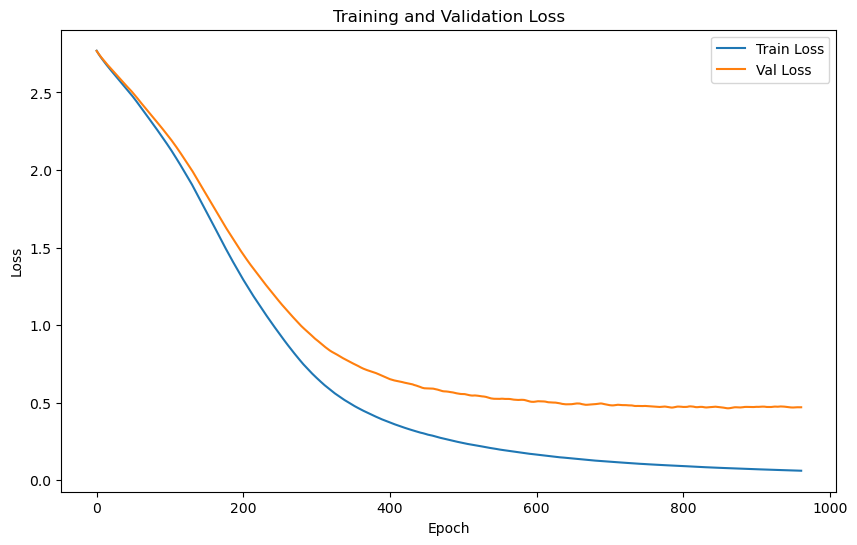

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9954 | Test Accuracy: 78.00%


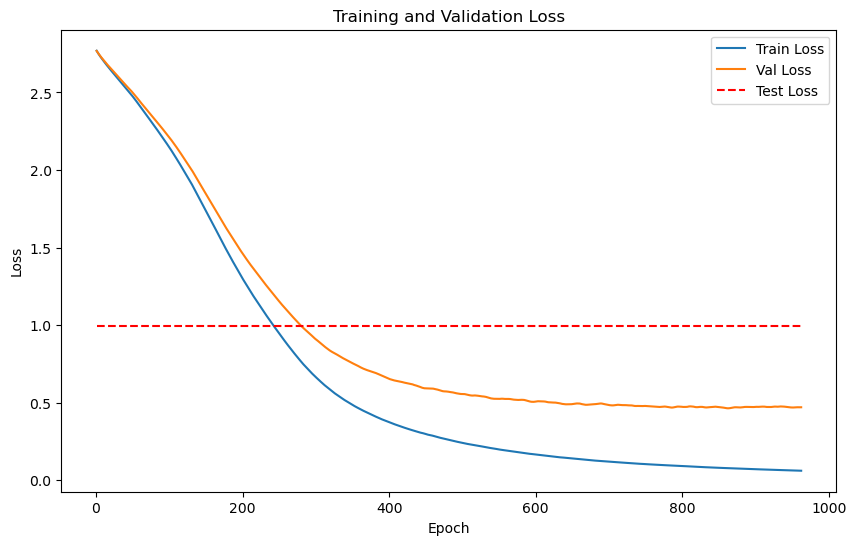

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


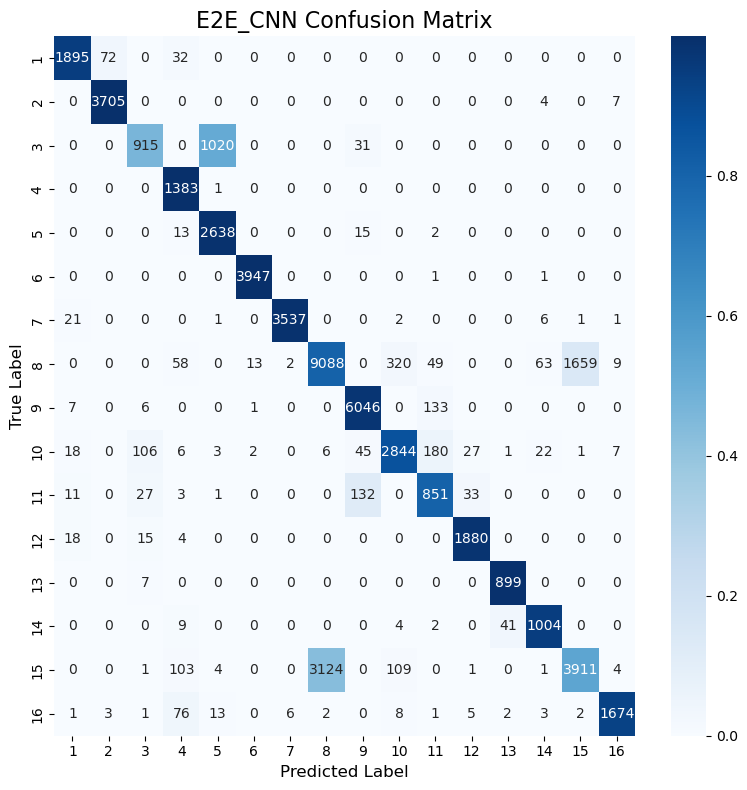

Classification Accuracy: 85.64%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


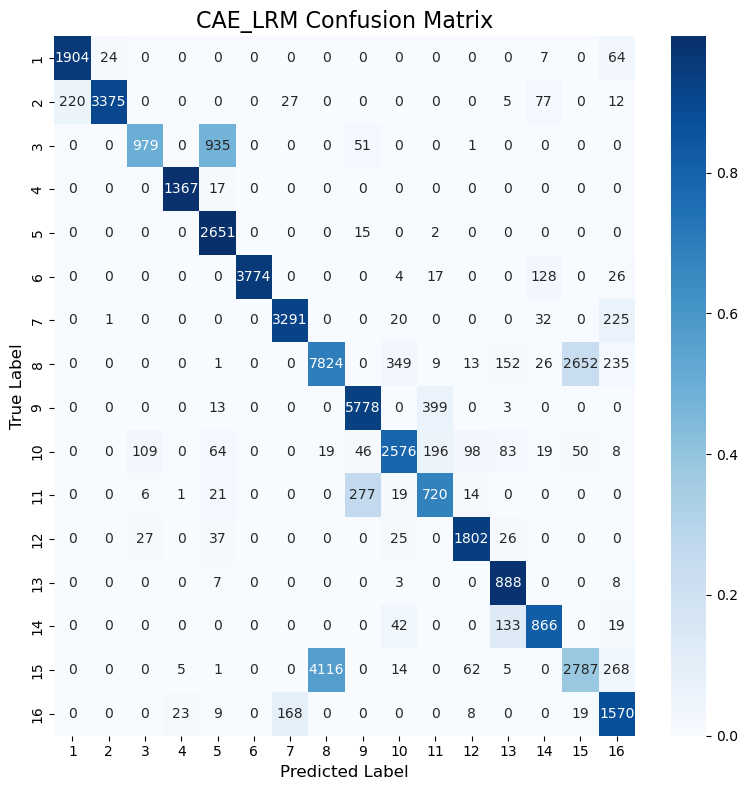

Classification Accuracy: 78.10%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


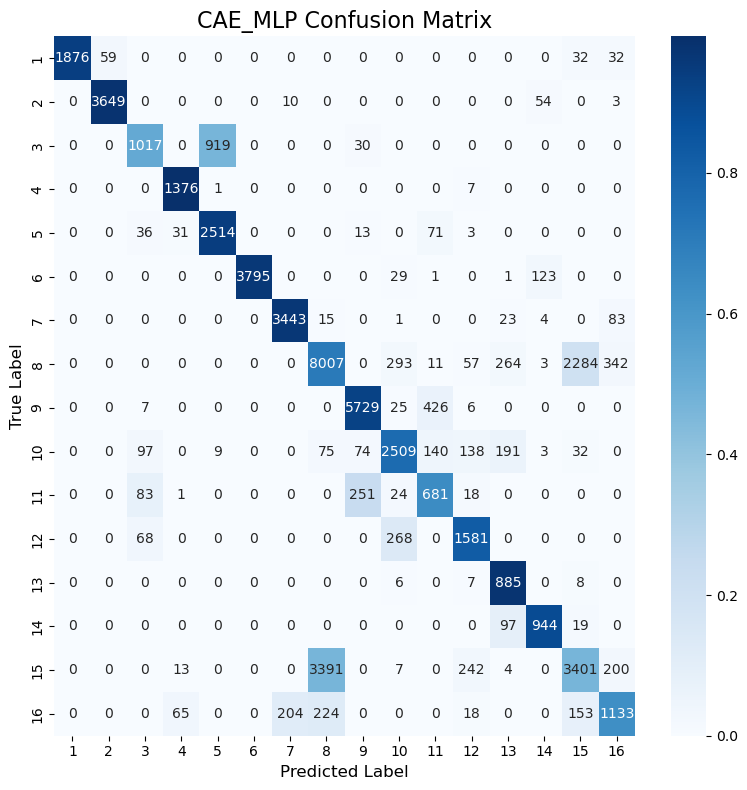

Classification Accuracy: 78.82%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


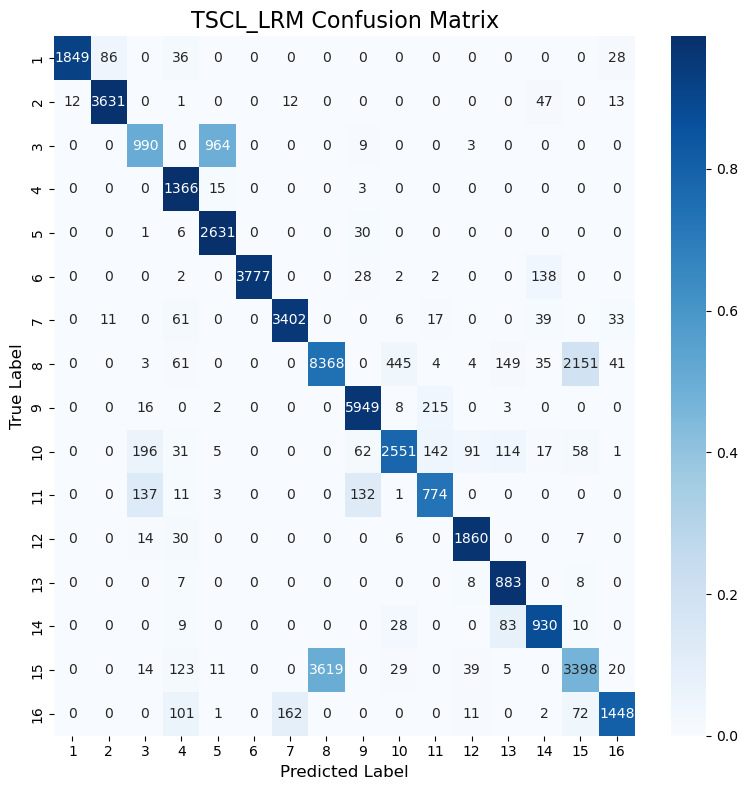

Classification Accuracy: 81.17%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


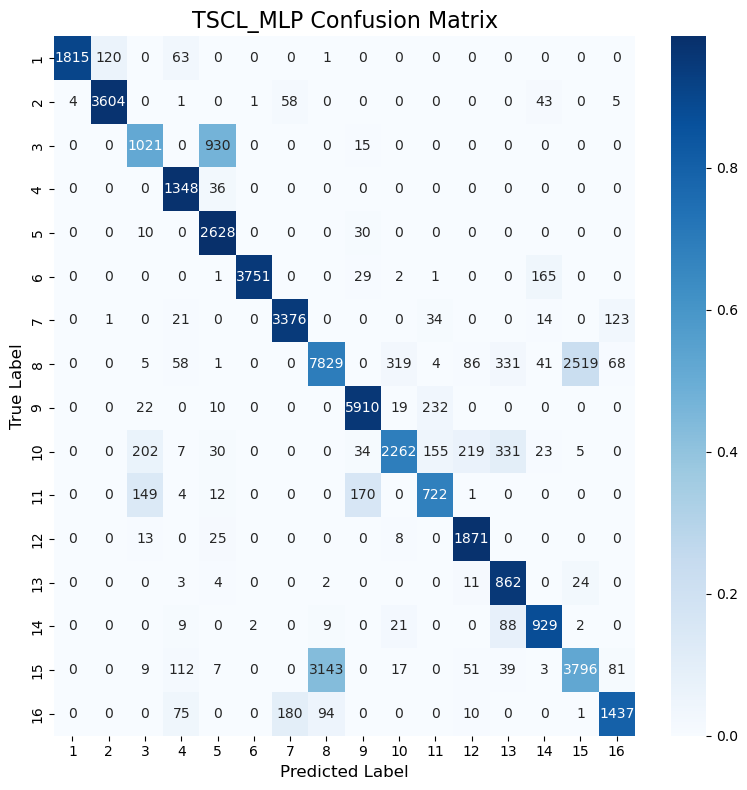

Classification Accuracy: 79.97%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


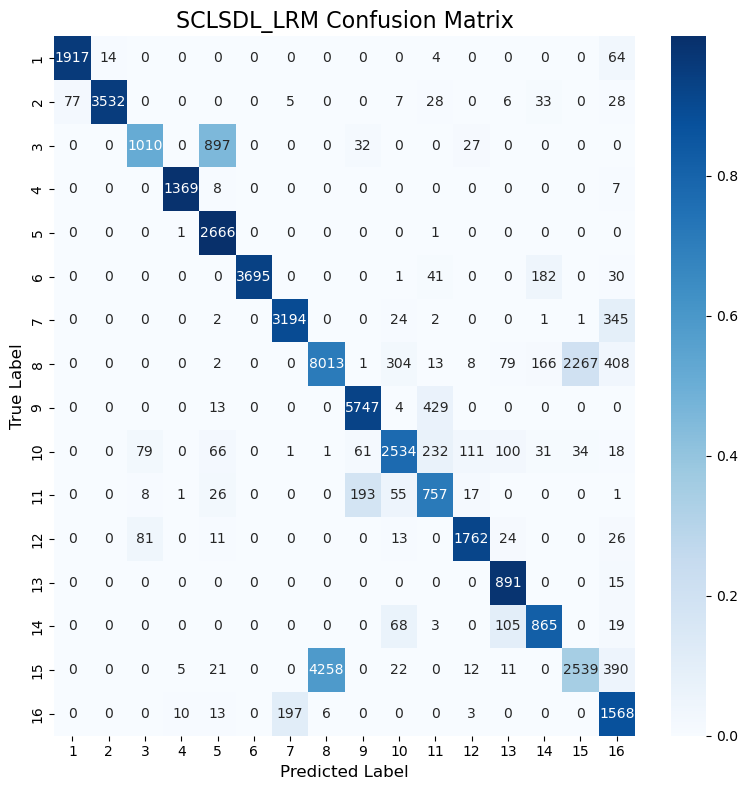

Classification Accuracy: 77.93%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


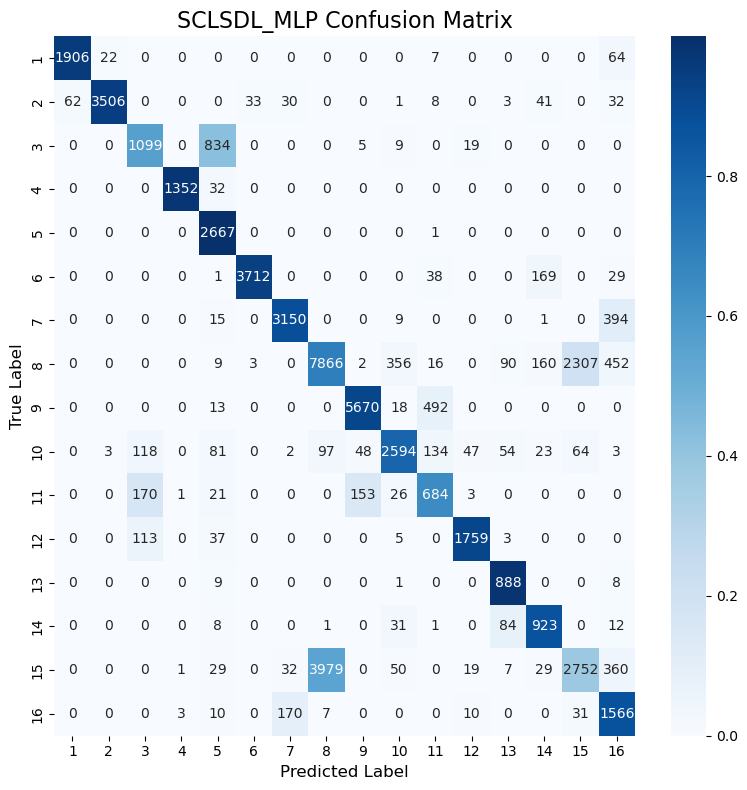

Classification Accuracy: 78.00%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          85.64
1    LRM (CAE)          78.10
2    MLP (CAE)          78.82
3     TSCL LRM          81.17
4     TSCL MLP          79.97
5  SCL_SDL LRM          77.93
6  SCL_SDL MLP          78.00



In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          85.64
3     TSCL LRM          81.17
4     TSCL MLP          79.97
2    MLP (CAE)          78.82
1    LRM (CAE)          78.10
6  SCL_SDL MLP          78.00
5  SCL_SDL LRM          77.93
